In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


#### Set Path and Constant Values

In [4]:
import sys
import os

# Set Constants
ROOT_PATH = "/content/drive/MyDrive/Colab Notebooks/HW2"  # Google Drive için kök dizin
CFG_PATH = os.path.join(ROOT_PATH, 'cfg')
DATA_PATH = os.path.join(ROOT_PATH, 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
EMBEDDING_DATA_PATH = os.path.join(DATA_PATH, 'embedding')
MDL_STATS_PATH = os.path.join(ROOT_PATH, 'model_stats')
sys.path.append(os.path.join(ROOT_PATH, 'src'))

# Create Folders if not exist
os.makedirs(RAW_DATA_PATH, exist_ok=True)
os.makedirs(EMBEDDING_DATA_PATH, exist_ok=True)
os.makedirs(MDL_STATS_PATH, exist_ok=True)

## Turkish Product Reviews

### Import Libraries

In [5]:
import pandas as pd
import numpy as np
import json
import pickle

from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report

from utils import get_project_config
from utils import missing_values
import time
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')
%matplotlib inline

<Figure size 800x600 with 0 Axes>

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

warnings.filterwarnings('ignore')

### Embedding Models

In [8]:
embedding_models = [
    'sentence-transformers/all-MiniLM-L12-v2',
    "jinaai/jina-embeddings-v3",
    "intfloat/multilingual-e5-large-instruct",
    "BAAI/bge-m3",
    "thenlper/gte-large"
]

embedding_models_dict = {
    "All Mini LM L12 v2": "sentence-transformers/all-MiniLM-L12-v2",
    "Jina Embeddings v3": "jinaai/jina-embeddings-v3",
    "Int Float Multilingual E5 Large Instruct": "intfloat/multilingual-e5-large-instruct",
    "BAAI BGE M3": "BAAI/bge-m3",
    "Thenlper Gte Large" : "thenlper/gte-large"
}

## Import Dataset: HepsiBurada Product Reviews

In [9]:
df_hb_data = pd.read_csv(os.path.join(RAW_DATA_PATH, "hb_tr_product_reviews.csv.gz"), compression='gzip')
df_hb_data[['sentence', 'sentiment']].head(3)

sentence  \
0                                                                       fena değil paraya göre iyi.   
1  ürün kaliteli ve çok kullanışlı kargo ya verilmesi ve elime çabuk ulaşması da gayet başarılı idi   
2    fiyat-performans karşılaştırması yaptığınızda gayet iyi bir ürün. en önemlisi ısınma yapmıyor.   

   sentiment  
0          1  
1          1  
2          1

In [10]:
df_emb_data_1 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "hb_sentence-transformers__all-MiniLM-L12-v2_embeddings.csv.gz"), compression='gzip')
df_emb_data_1.head(3)

sentence  \
0                                                                                    mükemmel bir filtre kağıdı....teşekkürler....   
1  ürün bugün elime geçti, yorgan battaniye hepsini poşetledim çok az yer kaplıyor ve yorganlar tertemiz kalıyor en önemlisi de bu   
2  cihaz çok güzel ve şık satıcı nasıl yaptıysa taa adananın rize ye 24 saat dolmadan cihazı ulaştırdı helal olsun çok teşekkürler   

   sentiment  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0          1    -0.029778    -0.040093    -0.031347     0.000506    -0.059388   
1          1    -0.145578    -0.006586    -0.044935    -0.016288    -0.049059   
2          1    -0.039318    -0.054284    -0.052456     0.051183    -0.021190   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  \
0    -0.102234     0.015345     0.002197     0.002212    -0.059579   
1    -0.034717     0.073080    -0.011394     0.029229    -0.032183   
2    -0.065515     0.091362    -0.040330    -0.013863    -0.012645   

   embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  \
0      0.005965     -0.043414     -0.044636      0.041878      0.101860   
1     -0.077151     -0.022365     -0.085678      0.037742      0.077807   
2     -0.010949      0.013010     -0.044129     -0.012737      0.108330   

   embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  \
0     -0.054765     -0.007119      0.025081      0.017265     -0.033405   
1     -0.026066     -0.010493     -0.038724     -0.108169     -0.011399   
2     -0.064219     -0.101187      0.052893     -0.061155     -0.081379   

   embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  \
0     -0.036067     -0.020863      0.051745     -0.036332     -0.014841   
1     -0.028376      0.040659      0.044962     -0.004774      0.012527   
2     -0.003099     -0.022541      0.076129      0.000726      0.026815   

   embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  \
0     -0.079107     -0.012383     -0.050864     -0.041605     -0.003153   
1     -0.120178      0.043221      0.029586      0.027017     -0.017343   
2     -0.117431      0.006216     -0.073654     -0.022386      0.029072   

   embedding_30  embedding_31  embedding_32  embedding_33  embedding_34  \
0     -0.047139     -0.009347     -0.013587     -0.009853     -0.012224   
1     -0.022052      0.108025      0.089918      0.015292     -0.067219   
2     -0.059612      0.027212      0.023216     -0.019784     -0.050312   

   embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  \
0      0.001687      0.018301      0.044562      0.060568     -0.034180   
1      0.063052     -0.012163      0.043128      0.005789     -0.016342   
2      0.027240      0.033374      0.037906      0.037059     -0.005251   

   embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  \
0      0.017962     -0.048379      0.014643     -0.025346      0.010699   
1      0.025240      0.016742      0.075370     -0.011486     -0.052290   
2     -0.019928     -0.070600     -0.028995     -0.063663     -0.004769   

   embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  \
0      0.062485      0.033939     -0.034179     -0.020273      0.018220   
1     -0.053725     -0.043621      0.038926      0.071979     -0.061501   
2     -0.016324      0.030541     -0.017372      0.037116     -0.037047   

   embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  \
0     -0.103356     -0.045759     -0.002822      0.023815      0.005062   
1     -0.054852     -0.075602     -0.029325     -0.027338      0.036927   
2     -0.075221     -0.029444     -0.092758     -0.045996      0.042043   

   embedding_55  embedding_56  embedding_57  embedding_58  embedding_59  \
0     -0.085412      0.032752     -0.042758     -0.023540      0.025495   
1     -0.045699      0.034507     -0.012873     -0.024577      0.001657   
2     -0.037310     -0.028648     -0.006360  

In [11]:
df_emb_data_2 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "hb_jinaai__jina-embeddings-v3_embeddings.csv.gz"), compression='gzip')
df_emb_data_2.head(3)

sentence  \
0                                                                                    mükemmel bir filtre kağıdı....teşekkürler....   
1  ürün bugün elime geçti, yorgan battaniye hepsini poşetledim çok az yer kaplıyor ve yorganlar tertemiz kalıyor en önemlisi de bu   
2  cihaz çok güzel ve şık satıcı nasıl yaptıysa taa adananın rize ye 24 saat dolmadan cihazı ulaştırdı helal olsun çok teşekkürler   

   sentiment  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0          1     0.041504    -0.035156     0.007446     0.006989     0.009705   
1          1    -0.083984    -0.035889     0.028931     0.009766     0.033203   
2          1     0.001686    -0.125000     0.080078     0.034180     0.088867   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  \
0    -0.003220    -0.061035     0.137695    -0.023315     0.078125   
1    -0.052979    -0.117676     0.187500     0.059570    -0.001366   
2     0.025391    -0.064941     0.233398    -0.051514    -0.019531   

   embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  \
0     -0.083008      0.177734      0.002487     -0.096191     -0.081543   
1     -0.096680      0.124023     -0.074219     -0.060791     -0.117676   
2     -0.034180      0.097168     -0.040283     -0.037842     -0.136719   

   embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  \
0     -0.012024     -0.176758      0.066895      0.092773      0.009827   
1     -0.057129     -0.221680      0.062988      0.044434      0.001060   
2     -0.095215     -0.103027      0.083008      0.013489      0.078613   

   embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  \
0     -0.087891      0.069336      0.029785     -0.008667     -0.086426   
1     -0.044922      0.008240      0.039551      0.091797      0.008240   
2     -0.116211      0.033447     -0.025024      0.068359     -0.095703   

   embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  \
0      0.066406     -0.025513      0.032227     -0.122070      0.146484   
1      0.085449     -0.005066      0.033203     -0.121094      0.019897   
2      0.077148      0.050781      0.078125     -0.050293      0.078125   

   embedding_30  embedding_31  embedding_32  embedding_33  embedding_34  \
0      0.068359      0.005585     -0.108398     -0.072266     -0.009460   
1      0.060547      0.078125      0.016235     -0.053467     -0.045898   
2     -0.037598     -0.004395      0.067383     -0.042969     -0.012573   

   embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  \
0      0.069336      0.077637     -0.049072     -0.015503      0.041992   
1      0.032715      0.071777      0.027100     -0.018921      0.002899   
2      0.111328     -0.039307     -0.012329     -0.000241     -0.021240   

   embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  \
0      0.031250     -0.071777      0.061035      0.011292      0.008972   
1     -0.006042      0.020508     -0.023193     -0.000507      0.018677   
2     -0.011108     -0.007812     -0.007050      0.031250      0.051025   

   embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  \
0      0.011475     -0.034180      0.005646     -0.052490      0.019165   
1     -0.034424     -0.048828      0.033203     -0.009827      0.076660   
2      0.034912     -0.015869      0.016968     -0.094727      0.081055   

   embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  \
0      0.066895      0.000362     -0.048096     -0.020630     -0.014221   
1      0.016235     -0.011047     -0.053467      0.016479      0.025269   
2      0.017212     -0.020264     -0.004761      0.012695      0.029663   

   embedding_55  embedding_56  embedding_57  embedding_58  embedding_59  \
0      0.002930      0.019409     -0.075684      0.002457     -0.007751   
1      0.085938      0.020020     -0.018799      0.041260      0.000801   
2      0.009399     -0.028198     -0.051025  

In [12]:
df_emb_data_3 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "hb_intfloat__multilingual-e5-large-instruct_embeddings.csv.gz"), compression='gzip')
df_emb_data_3.head(3)

sentence  \
0                                                                                    mükemmel bir filtre kağıdı....teşekkürler....   
1  ürün bugün elime geçti, yorgan battaniye hepsini poşetledim çok az yer kaplıyor ve yorganlar tertemiz kalıyor en önemlisi de bu   
2  cihaz çok güzel ve şık satıcı nasıl yaptıysa taa adananın rize ye 24 saat dolmadan cihazı ulaştırdı helal olsun çok teşekkürler   

   sentiment  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0          1     0.027284     0.020753    -0.010054    -0.034226     0.033674   
1          1     0.022991     0.026251    -0.040306    -0.018694     0.009763   
2          1     0.016297     0.030838    -0.026917    -0.050332     0.018672   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  \
0    -0.039205    -0.012834     0.014824     0.030908    -0.035529   
1    -0.037737    -0.021987     0.031786     0.020995    -0.017735   
2    -0.017294    -0.030993     0.017347     0.035048    -0.028435   

   embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  \
0      0.029059      0.029101     -0.011556     -0.034244     -0.023727   
1      0.027808      0.054331     -0.040461     -0.017323     -0.036390   
2      0.027005      0.059653     -0.018956     -0.005829     -0.023121   

   embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  \
0     -0.029461      0.006688      0.021106     -0.023607     -0.024192   
1     -0.031981     -0.020929      0.013616     -0.022250     -0.033023   
2     -0.029214     -0.008834      0.010147     -0.004356     -0.036891   

   embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  \
0      0.038434     -0.006749     -0.005627     -0.054070     -0.029563   
1      0.044567     -0.018267     -0.015488     -0.035687      0.000189   
2      0.041850     -0.002545     -0.018488     -0.039247     -0.008087   

   embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  \
0     -0.004303     -0.031166     -0.045333     -0.016799     -0.024359   
1     -0.015101     -0.042480     -0.026360     -0.060471     -0.040277   
2     -0.016474     -0.017756     -0.027295     -0.007877     -0.044064   

   embedding_30  embedding_31  embedding_32  embedding_33  embedding_34  \
0      0.007512      0.024036     -0.015966     -0.023679      0.000213   
1      0.016047      0.043110     -0.011593     -0.008001     -0.056836   
2      0.005310      0.034989     -0.020079     -0.036048     -0.037974   

   embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  \
0      0.051942      0.012304      0.025667     -0.014667      0.060777   
1      0.063842      0.032140      0.070697     -0.020295      0.065149   
2      0.030375      0.027940      0.054222     -0.036159      0.065206   

   embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  \
0     -0.014481      0.054358      0.009450     -0.033581     -0.019315   
1     -0.020200      0.028399      0.000871     -0.024672     -0.006540   
2     -0.014209      0.049623      0.007759     -0.029565     -0.012488   

   embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  \
0      0.025258      0.051206      0.003536     -0.001874      0.040176   
1      0.007763      0.057322      0.007945     -0.019038      0.051551   
2     -0.005139      0.056127     -0.011530      0.000421      0.046725   

   embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  \
0      0.023454      0.006281     -0.003257     -0.041612     -0.057024   
1      0.045709      0.017861     -0.020303     -0.032469     -0.025425   
2      0.044802      0.029850     -0.021765     -0.021436     -0.025791   

   embedding_55  embedding_56  embedding_57  embedding_58  embedding_59  \
0      0.034463     -0.037251      0.004327     -0.013028      0.026295   
1      0.054914     -0.046386      0.015608      0.003094      0.037604   
2      0.051101     -0.006316     -0.008082  

In [13]:
df_emb_data_4 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "hb_BAAI__bge-m3_embeddings.csv.gz"), compression='gzip')
df_emb_data_4.head(3)

sentence  \
0                                                                                    mükemmel bir filtre kağıdı....teşekkürler....   
1  ürün bugün elime geçti, yorgan battaniye hepsini poşetledim çok az yer kaplıyor ve yorganlar tertemiz kalıyor en önemlisi de bu   
2  cihaz çok güzel ve şık satıcı nasıl yaptıysa taa adananın rize ye 24 saat dolmadan cihazı ulaştırdı helal olsun çok teşekkürler   

   sentiment  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0          1    -0.030010    -0.007341    -0.050919    -0.012627     0.000710   
1          1    -0.002010     0.033999    -0.055120     0.022962    -0.024765   
2          1     0.003407     0.040464    -0.024939     0.021446    -0.037463   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  \
0    -0.055775     0.004987    -0.026070     0.022987     0.014933   
1    -0.093510     0.006075     0.029692     0.006365     0.010241   
2    -0.007703     0.005230    -0.032891    -0.044842     0.016109   

   embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  \
0      0.010350     -0.002769      0.023203      0.006218      0.019121   
1     -0.002854      0.042781     -0.044115     -0.016515      0.031589   
2      0.000696      0.074079     -0.006173     -0.009360      0.014124   

   embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  \
0     -0.000413     -0.018149     -0.008839     -0.011359     -0.051610   
1     -0.000128      0.024443     -0.059359     -0.017833     -0.029782   
2      0.004445      0.011134     -0.014037      0.055340     -0.045666   

   embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  \
0     -0.050660     -0.013238      0.025216      0.008142     -0.024863   
1     -0.007072     -0.048642      0.031109      0.014515      0.022312   
2      0.018801      0.024347      0.019696      0.000707      0.005373   

   embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  \
0      0.032734      0.047665     -0.011945      0.012321     -0.005688   
1      0.012728      0.004723      0.019117      0.005255     -0.008737   
2      0.021070      0.007626      0.042607      0.063621     -0.004011   

   embedding_30  embedding_31  embedding_32  embedding_33  embedding_34  \
0     -0.016011     -0.005908      0.038778      0.046836      0.013627   
1      0.004578      0.052223      0.051516      0.037265     -0.061100   
2     -0.026929      0.022076     -0.012096     -0.018641     -0.058462   

   embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  \
0     -0.011550      0.007773     -0.008496     -0.040485      0.005627   
1     -0.043082      0.020411      0.008899     -0.020293      0.020555   
2     -0.013507      0.004731     -0.020554     -0.041447      0.022548   

   embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  \
0     -0.038351      0.005306      0.016497     -0.037311     -0.030308   
1     -0.008630     -0.017844     -0.002248      0.008983     -0.006826   
2     -0.000920      0.001419     -0.013605      0.009008      0.036652   

   embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  \
0     -0.009671     -0.005867     -0.019367     -0.039028     -0.027474   
1     -0.036180     -0.048762     -0.007936     -0.057363     -0.000895   
2     -0.055144     -0.018148     -0.014065     -0.041710     -0.030950   

   embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  \
0      0.003685     -0.005706      0.038462     -0.019002      0.013384   
1      0.018422     -0.030670      0.015514     -0.041592      0.017099   
2      0.045088     -0.012367      0.029824     -0.033989     -0.007268   

   embedding_55  embedding_56  embedding_57  embedding_58  embedding_59  \
0      0.047138     -0.026742     -0.011035      0.016974      0.032194   
1      0.064596      0.012072     -0.006768      0.003561      0.026231   
2      0.027118      0.026589     -0.042532  

In [14]:
df_emb_data_5 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "hb_thenlper__gte-large_embeddings.csv.gz"), compression='gzip')
df_emb_data_5.head(3)

sentence  \
0                                                                                    mükemmel bir filtre kağıdı....teşekkürler....   
1  ürün bugün elime geçti, yorgan battaniye hepsini poşetledim çok az yer kaplıyor ve yorganlar tertemiz kalıyor en önemlisi de bu   
2  cihaz çok güzel ve şık satıcı nasıl yaptıysa taa adananın rize ye 24 saat dolmadan cihazı ulaştırdı helal olsun çok teşekkürler   

   sentiment  embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0          1    -0.032191    -0.012243    -0.002628     0.019241    -0.024240   
1          1    -0.005259    -0.033415    -0.016350    -0.003429    -0.019307   
2          1    -0.002494    -0.009853     0.002290    -0.003056    -0.045437   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  \
0    -0.004898    -0.019812     0.028693    -0.012582     0.027546   
1    -0.012333    -0.025417     0.051979    -0.000244     0.021291   
2    -0.005783    -0.002639     0.048111     0.023965     0.027693   

   embedding_10  embedding_11  embedding_12  embedding_13  embedding_14  \
0      0.042775      0.002026      0.021764     -0.038770     -0.032300   
1      0.029608     -0.019951      0.020630     -0.018471     -0.044001   
2      0.041228     -0.006849      0.014991     -0.012178     -0.010852   

   embedding_15  embedding_16  embedding_17  embedding_18  embedding_19  \
0     -0.013638     -0.009757     -0.034895      0.003777      0.000668   
1     -0.015418     -0.026686     -0.030144      0.004636     -0.009261   
2     -0.002488     -0.025596     -0.024024      0.017714      0.005412   

   embedding_20  embedding_21  embedding_22  embedding_23  embedding_24  \
0      0.022067      0.013660     -0.056249     -0.003728     -0.027356   
1     -0.010076      0.015732     -0.094380     -0.024788     -0.008535   
2     -0.000366      0.034170     -0.068581     -0.019424     -0.031162   

   embedding_25  embedding_26  embedding_27  embedding_28  embedding_29  \
0      0.040528     -0.001964     -0.023183      0.053768      0.077261   
1      0.041734      0.012030     -0.001177      0.055671      0.076309   
2      0.029310      0.004499     -0.033652      0.055759      0.058738   

   embedding_30  embedding_31  embedding_32  embedding_33  embedding_34  \
0      0.007880     -0.011974      0.009783     -0.046075     -0.016576   
1      0.008221     -0.023540      0.012543     -0.056813     -0.010740   
2     -0.008503     -0.020594      0.029180     -0.071135     -0.004675   

   embedding_35  embedding_36  embedding_37  embedding_38  embedding_39  \
0     -0.034458      0.032699     -0.012048     -0.025407     -0.062812   
1     -0.027574      0.029073     -0.028954      0.020566     -0.024737   
2     -0.013309      0.046152     -0.035054      0.006935     -0.043115   

   embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  \
0      0.004674     -0.034453      0.026603     -0.021595     -0.009481   
1      0.002652     -0.018517      0.010126     -0.039360     -0.027508   
2      0.007095     -0.021975      0.012039     -0.027233     -0.010127   

   embedding_45  embedding_46  embedding_47  embedding_48  embedding_49  \
0     -0.030665     -0.002998     -0.039512     -0.025243     -0.022514   
1      0.004237      0.014135     -0.056071      0.015294     -0.015511   
2     -0.029862     -0.034590     -0.047668      0.001247     -0.020941   

   embedding_50  embedding_51  embedding_52  embedding_53  embedding_54  \
0      0.013436     -0.020272      0.035098     -0.023830     -0.013933   
1      0.015685     -0.002571      0.032627     -0.004351      0.001515   
2      0.014992     -0.012219      0.038262     -0.020178      0.015593   

   embedding_55  embedding_56  embedding_57  embedding_58  embedding_59  \
0      0.019388      0.015184     -0.003641     -0.036622      0.042062   
1     -0.007680      0.017068     -0.012164     -0.031506      0.033309   
2     -0.015254      0.013513     -0.025480  

In [15]:
print(f"Emb. Model Name: {embedding_models[0]} & Data Shape: {df_emb_data_1.shape}")
print(f"Emb. Model Name: {embedding_models[1]} & Data Shape: {df_emb_data_2.shape}")
print(f"Emb. Model Name: {embedding_models[2]} & Data Shape: {df_emb_data_3.shape}")
print(f"Emb. Model Name: {embedding_models[3]} & Data Shape: {df_emb_data_4.shape}")
print(f"Emb. Model Name: {embedding_models[4]} & Data Shape: {df_emb_data_5.shape}")

Emb. Model Name: sentence-transformers/all-MiniLM-L12-v2 & Data Shape: (7500, 386)
Emb. Model Name: jinaai/jina-embeddings-v3 & Data Shape: (7500, 1026)
Emb. Model Name: intfloat/multilingual-e5-large-instruct & Data Shape: (7500, 1026)
Emb. Model Name: BAAI/bge-m3 & Data Shape: (7500, 1026)
Emb. Model Name: thenlper/gte-large & Data Shape: (7500, 1026)


## Modelling

#### K Fold Cross Validation

In [16]:
df_emb_data_list = [df_emb_data_1, df_emb_data_2, df_emb_data_3, df_emb_data_4, df_emb_data_5]

In [17]:
# K-fold Cross Validation Value 5, 10
k_fold_splits = 10

# Create K-fold object
kf = KFold(n_splits=k_fold_splits, shuffle=True, random_state=23)

### Model 1: Support Vector Machine(SVM) Model

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
1 sentence-transformers/all-MiniLM-L12-v2 - Embedding Data Shape: (7500, 386)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (384) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_379', 'embedding_380', 'embedding_381', 'embedding_382', 'embedding_383']
X Shape: (7500, 384) & y Shape: (7500,)
X_Train Shape: (6500, 384) & X_Test Shape: (1000, 384) & Y_Train Shape: (6500,) & Y_Test Shape: (1000,)

Id   Mean     StDev 					Params
1 0.715385 (0.017809) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
2 0.711231 (0.017515) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
3 0.716769 (0.011231) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
4 0.715385 (0.017809) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
5 0.510308 (0.067979) 

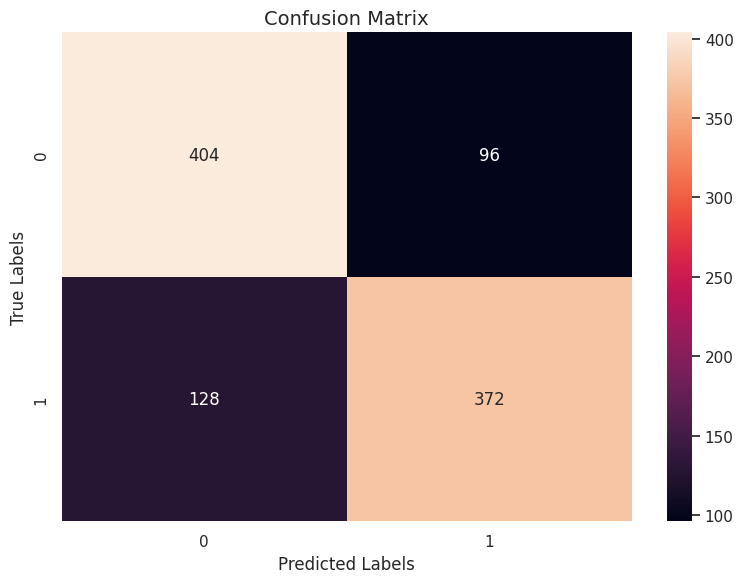

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       500
           1       0.79      0.74      0.77       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000

Test Accuracy: 0.776
Test F1 Score: 0.776
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
2 jinaai/jina-embeddings-v3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (1024) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_1019', 'embedding_1020', 'embedding_1021', 'embedding_1022', 'embedding_1023']
X Shape: (7500,

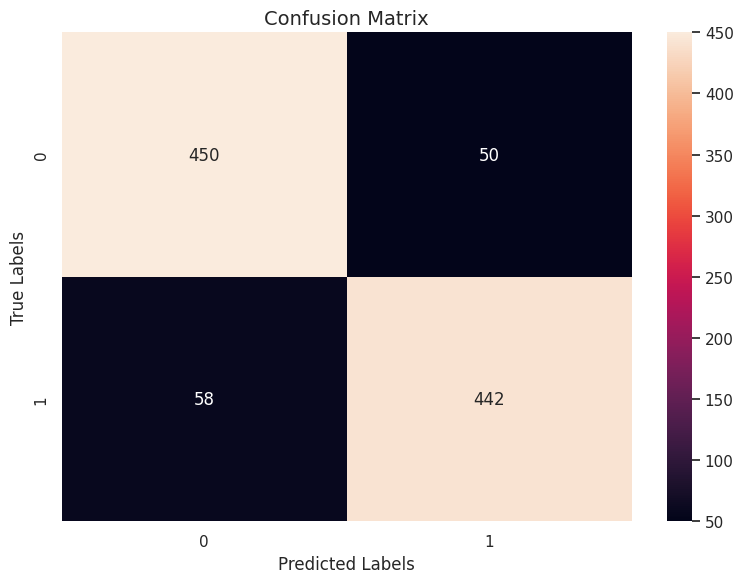

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       500
           1       0.90      0.88      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

Test Accuracy: 0.892
Test F1 Score: 0.892
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
3 intfloat/multilingual-e5-large-instruct - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (1024) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_1019', 'embedding_1020', 'embedding_1021', 'embedding_1022', 'embedding_1023']
X

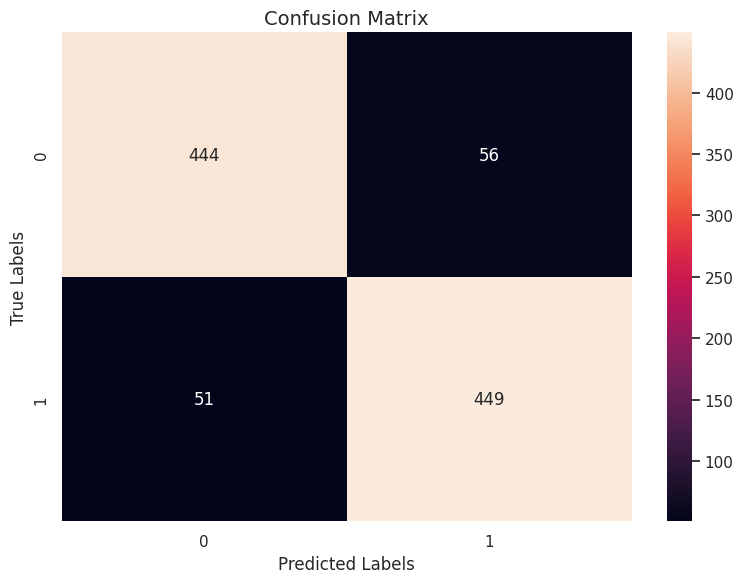

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       500
           1       0.89      0.90      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

Test Accuracy: 0.893
Test F1 Score: 0.893
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
4 BAAI/bge-m3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (1024) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_1019', 'embedding_1020', 'embedding_1021', 'embedding_1022', 'embedding_1023']
X Shape: (7500, 1024) & y Sha

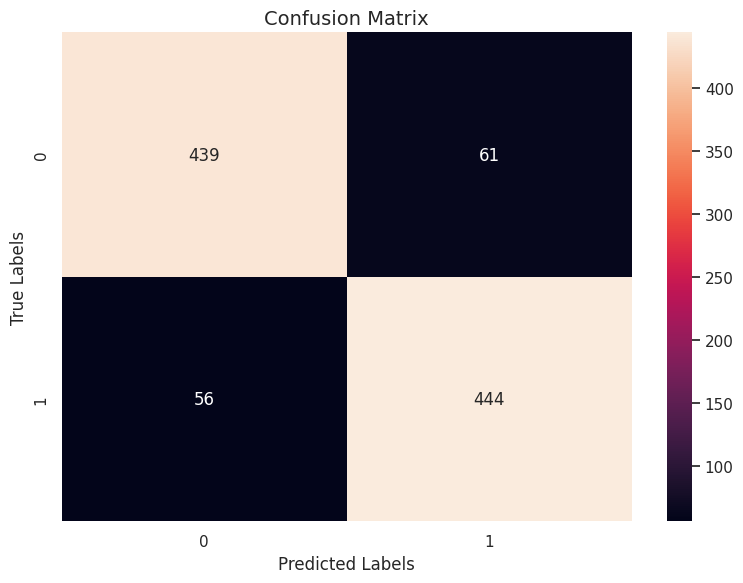

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       500
           1       0.88      0.89      0.88       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

Test Accuracy: 0.883
Test F1 Score: 0.883
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
5 thenlper/gte-large - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (1024) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_1019', 'embedding_1020', 'embedding_1021', 'embedding_1022', 'embedding_1023']
X Shape: (7500, 1024) 

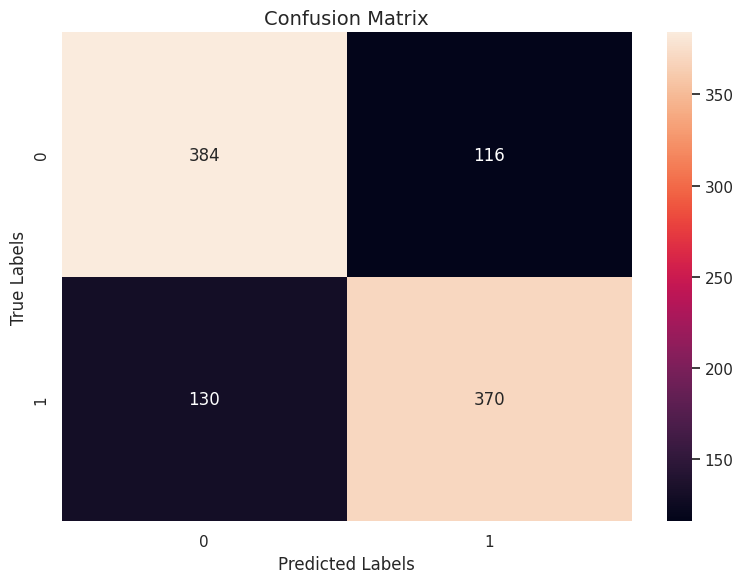

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       500
           1       0.76      0.74      0.75       500

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000

Test Accuracy: 0.754
Test F1 Score: 0.754
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
CPU times: user 1min 32s, sys: 9.43 s, total: 1min 41s
Wall time: 45min 46s


In [18]:
%%time

model_stats_svm = {}

for idx, df_emb_data in enumerate(df_emb_data_list):
    print("# " * 50)
    print(f"{idx+1} {embedding_models[idx]} - Embedding Data Shape: {df_emb_data.shape}")
    print("# " * 50)
    print("Target Unique Values:", df_emb_data['sentiment'].unique())

    feature_columns = [col for col in df_emb_data.columns if 'embedding_' in col]
    print(f"Feature Columns: ({len(feature_columns)}) & {feature_columns[0:5]} ... {feature_columns[len(feature_columns)-5:]}")

    X = df_emb_data[feature_columns].values
    y = df_emb_data['sentiment'].values
    print(f"X Shape: {X.shape} & y Shape: {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
    print(f"X_Train Shape: {X_train.shape} & X_Test Shape: {X_test.shape} & Y_Train Shape: {y_train.shape} & Y_Test Shape: {y_test.shape}")

    X_train.shape, y_train.shape, X_test.shape, y_test.shape

    # Parametre Values for SVM Model
    svm_param_dist = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }

    # SVM CLassifier modeli
    svm_clf = SVC()

    # Grid Search
    svm_random_model = GridSearchCV(svm_clf, svm_param_dist, scoring='accuracy', cv=kf, n_jobs=-1)


    svm_model = svm_random_model.fit(X_train, y_train)

    svm_random_model_best_estimator = svm_model.best_estimator_
    svm_random_model_best_params = svm_model.best_params_
    svm_random_model_best_score = svm_model.best_score_

    # Model Performans Evaluate
    # svm_random_scores = cross_val_score(svm_random_model_best_estimator, X_train, y_train, cv=kf, scoring='accuracy')

    means = svm_model.cv_results_['mean_test_score']
    stds = svm_model.cv_results_['std_test_score']
    params = svm_model.cv_results_['params']

    print()
    print("Id", "  Mean", "    StDev", "\t\t\t\t\tParams")
    for i, (mean, stdev, param) in enumerate(zip(means, stds, params)):
        print("%d %f (%f) with: %r" % (i+1, mean, stdev, param))

    # Summarize Results
    print()
    print("Best: %f using %s" % (svm_random_model_best_score, svm_random_model_best_params))
    print()

    y_pred = svm_random_model_best_estimator.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g');
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

    # Set labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true=y_test, y_pred=y_pred))

    acc_score = round(accuracy_score(y_true=y_test, y_pred=y_pred), 3)
    f1_score_ = round(f1_score(y_true=y_test, y_pred=y_pred, average='macro'), 3)
    print("Test Accuracy:", acc_score)
    print("Test F1 Score:", f1_score_)

    model_stats_svm[f"Emb_{idx+1}"] = {
        "train_best_score": svm_random_model_best_score,
        "train_best_params": svm_random_model_best_params,
        "test_accuracy": acc_score,
        "test_f1": f1_score_,
        "y_test": y_test,
        "y_pred": y_pred,
    }
    print("* " * 50)

### Model 2: Random Forest (RF) Model

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
1 sentence-transformers/all-MiniLM-L12-v2 - Embedding Data Shape: (7500, 386)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (384) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_379', 'embedding_380', 'embedding_381', 'embedding_382', 'embedding_383']
X Shape: (7500, 384) & y Shape: (7500,)
X_Train Shape: (6500, 384) & X_Test Shape: (1000, 384) & Y_Train Shape: (6500,) & Y_Test Shape: (1000,)

Id   Mean     StDev 					Params
1 0.696615 (0.018940) with: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
2 0.699385 (0.017758) with: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500}
3 0.696923 (0.013447) with: {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 200}
4 0.696154 (0.016051) with: {'max_depth': 10, 'min_

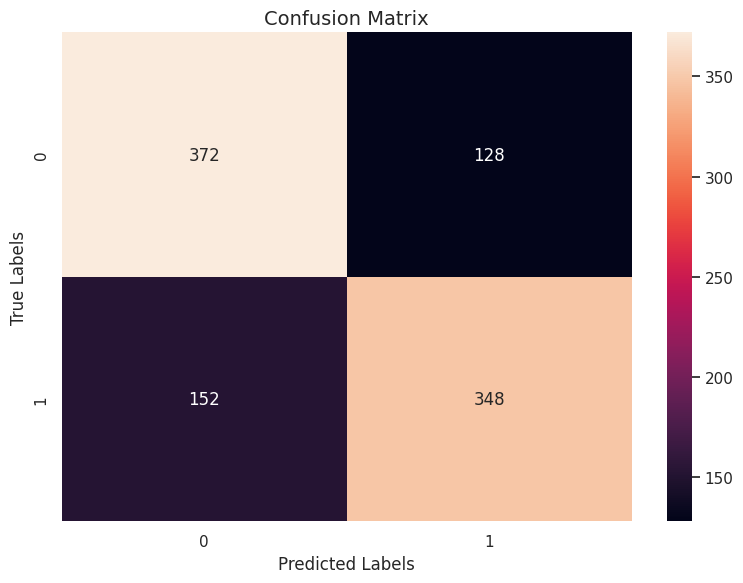

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       500
           1       0.73      0.70      0.71       500

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000

Test Accuracy: 0.72
Test F1 Score: 0.72
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
2 jinaai/jina-embeddings-v3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (1024) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_1019', 'embedding_1020', 'embedding_1021', 'embedding_1022', 'embedding_1023']
X Shape: (7500, 1

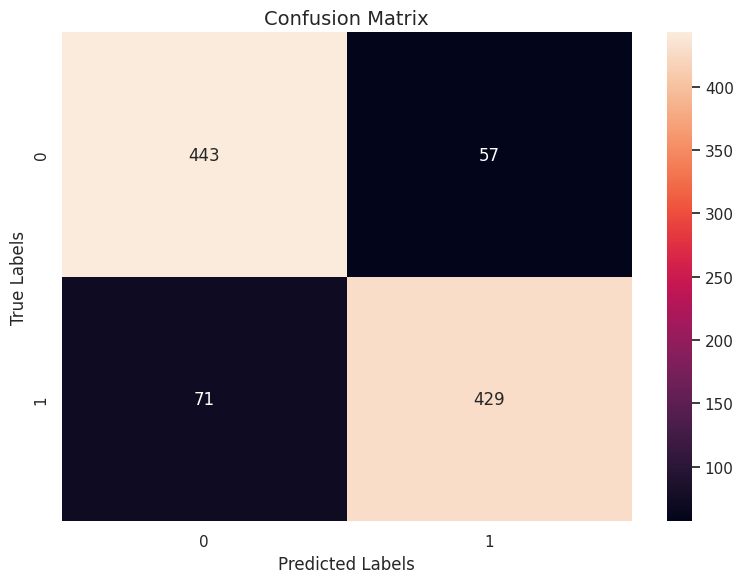

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       500
           1       0.88      0.86      0.87       500

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000

Test Accuracy: 0.872
Test F1 Score: 0.872
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
3 intfloat/multilingual-e5-large-instruct - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (1024) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_1019', 'embedding_1020', 'embedding_1021', 'embedding_1022', 'embedding_1023']
X

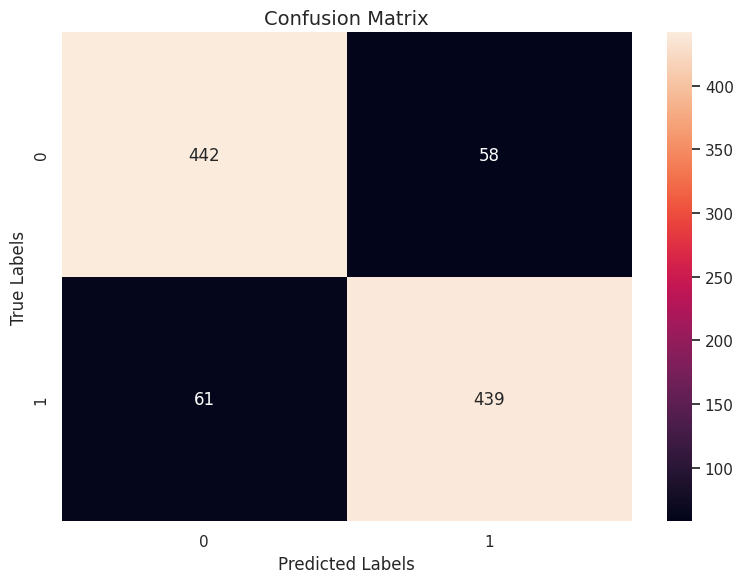

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       500
           1       0.88      0.88      0.88       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

Test Accuracy: 0.881
Test F1 Score: 0.881
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
4 BAAI/bge-m3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (1024) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_1019', 'embedding_1020', 'embedding_1021', 'embedding_1022', 'embedding_1023']
X Shape: (7500, 1024) & y Sha

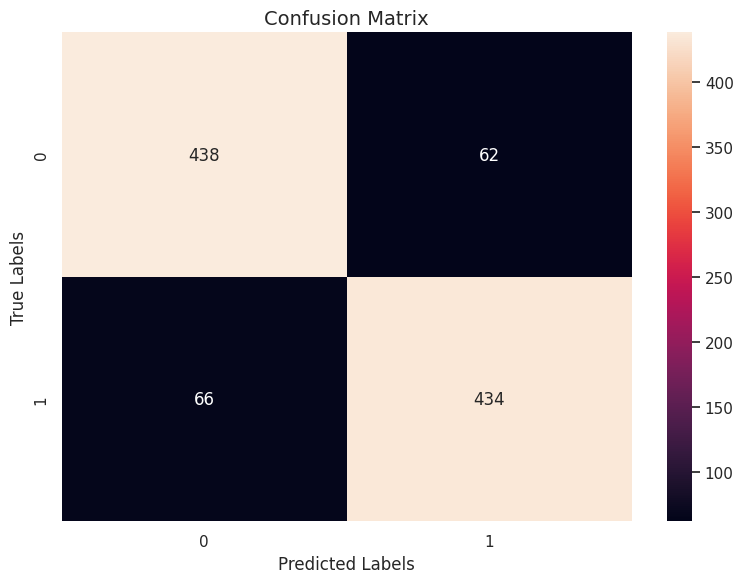

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       500
           1       0.88      0.87      0.87       500

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000

Test Accuracy: 0.872
Test F1 Score: 0.872
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
5 thenlper/gte-large - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (1024) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_1019', 'embedding_1020', 'embedding_1021', 'embedding_1022', 'embedding_1023']
X Shape: (7500, 1024) 

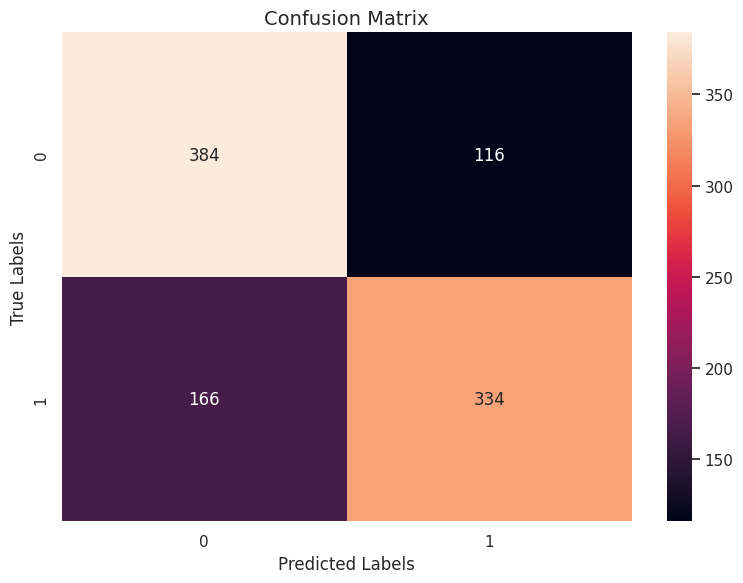

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       500
           1       0.74      0.67      0.70       500

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000

Test Accuracy: 0.718
Test F1 Score: 0.717
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
CPU times: user 9min 38s, sys: 6.31 s, total: 9min 44s
Wall time: 1h 1min 5s


In [20]:
%%time

model_stats_rf = {}

for idx, df_emb_data in enumerate(df_emb_data_list):
    print("# " * 50)
    print(f"{idx+1} {embedding_models[idx]} - Embedding Data Shape: {df_emb_data.shape}")
    print("# " * 50)
    print("Target Unique Values:", df_emb_data['sentiment'].unique())

    feature_columns = [col for col in df_emb_data.columns if 'embedding_' in col]
    print(f"Feature Columns: ({len(feature_columns)}) & {feature_columns[0:5]} ... {feature_columns[len(feature_columns)-5:]}")

    X = df_emb_data[feature_columns].values
    y = df_emb_data['sentiment'].values
    print(f"X Shape: {X.shape} & y Shape: {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
    print(f"X_Train Shape: {X_train.shape} & X_Test Shape: {X_test.shape} & Y_Train Shape: {y_train.shape} & Y_Test Shape: {y_test.shape}")

    X_train.shape, y_train.shape, X_test.shape, y_test.shape

    # Parametre Values for RF Model
    rf_param_dist = {
        'n_estimators': [200, 500],
        'max_depth': [10, None],
        'min_samples_split': [2, 3]
    }

    # RF Classifier Model
    rf_clf = RandomForestClassifier()

    # RF Model with Random Search
    rf_random_model = GridSearchCV(rf_clf, rf_param_dist, scoring='accuracy', cv=kf, n_jobs=-1)

    rf_model = rf_random_model.fit(X_train, y_train)

    rf_random_model_best_estimator = rf_model.best_estimator_
    rf_random_model_best_params = rf_model.best_params_
    rf_random_model_best_score = rf_model.best_score_

    means = rf_model.cv_results_['mean_test_score']
    stds = rf_model.cv_results_['std_test_score']
    params = rf_model.cv_results_['params']

    print()
    print("Id", "  Mean", "    StDev", "\t\t\t\t\tParams")
    for i, (mean, stdev, param) in enumerate(zip(means, stds, params)):
        print("%d %f (%f) with: %r" % (i+1, mean, stdev, param))

    # Summarize Results
    print()
    print("Best: %f using %s" % (rf_random_model_best_score, rf_random_model_best_params))
    print()

    y_pred = rf_random_model_best_estimator.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g');
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

    # Set labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true=y_test, y_pred=y_pred))

    acc_score = round(accuracy_score(y_true=y_test, y_pred=y_pred), 3)
    f1_score_ = round(f1_score(y_true=y_test, y_pred=y_pred, average='macro'), 3)
    print("Test Accuracy:", acc_score)
    print("Test F1 Score:", f1_score_)

    model_stats_rf[f"Emb_{idx+1}"] = {
        "train_best_score": rf_random_model_best_score,
        "train_best_params": rf_random_model_best_params,
        "test_accuracy": acc_score,
        "test_f1": f1_score_,
        "y_test": y_test,
        "y_pred": y_pred,
    }
    print("* " * 50)

### Model 3: Multi Layer Perceptron (MLP) Model

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
1 sentence-transformers/all-MiniLM-L12-v2 - Embedding Data Shape: (7500, 386)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (384) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_379', 'embedding_380', 'embedding_381', 'embedding_382', 'embedding_383']
X Shape: (7500, 384) & y Shape: (7500,)
X_Train Shape: (6500, 384) & X_Test Shape: (1000, 384) & Y_Train Shape: (6500,) & Y_Test Shape: (1000,)


/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_mult


Id   Mean     StDev 					Params
1 0.740769 (0.014104) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 50}
2 0.740769 (0.014104) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 50}
3 0.740923 (0.018945) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 50}
4 0.740923 (0.018945) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'max_iter': 50}
5 0.740154 (0.013296) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 50}
6 0.740154 (0.013296) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 50}
7 0.740462 (0.019509) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'lear

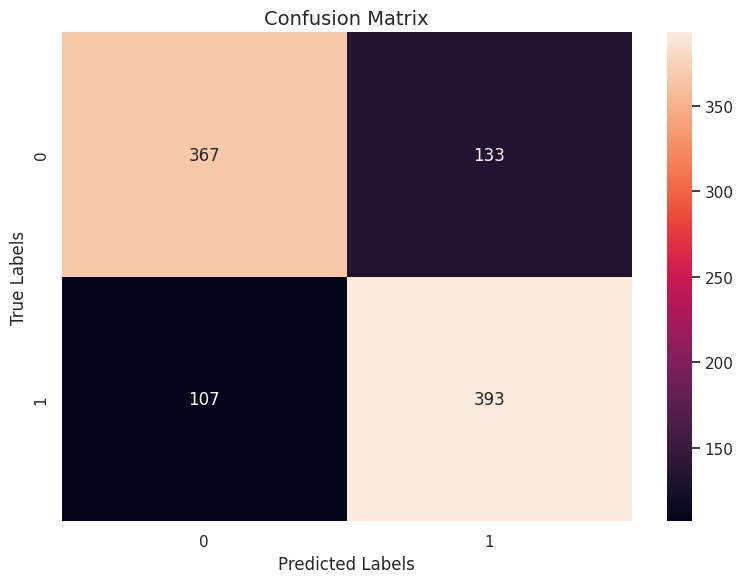

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       500
           1       0.75      0.79      0.77       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000

Test Accuracy: 0.76
Test F1 Score: 0.76
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
2 jinaai/jina-embeddings-v3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (1024) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_1019', 'embedding_1020', 'embedding_1021', 'embedding_1022', 'embedding_1023']
X Shape: (7500, 1

/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_mult


Id   Mean     StDev 					Params
1 0.878000 (0.011918) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 50}
2 0.878000 (0.011918) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 50}
3 0.870154 (0.011680) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 50}
4 0.870154 (0.011680) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'max_iter': 50}
5 0.878000 (0.011758) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 50}
6 0.878000 (0.011758) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 50}
7 0.870154 (0.011801) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'lear

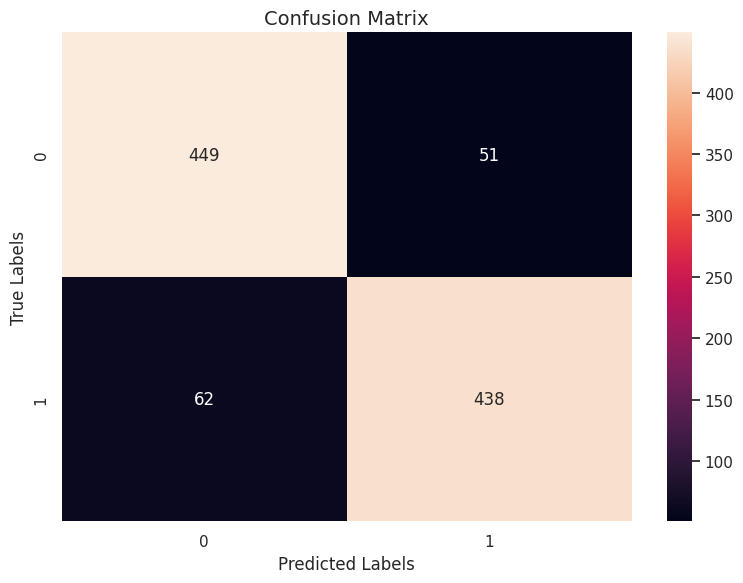

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       500
           1       0.90      0.88      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

Test Accuracy: 0.887
Test F1 Score: 0.887
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
3 intfloat/multilingual-e5-large-instruct - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (1024) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_1019', 'embedding_1020', 'embedding_1021', 'embedding_1022', 'embedding_1023']
X

/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_mult


Id   Mean     StDev 					Params
1 0.886769 (0.008976) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 50}
2 0.886769 (0.008976) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 50}
3 0.884769 (0.009545) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 50}
4 0.884769 (0.009545) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'max_iter': 50}
5 0.887077 (0.008762) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 50}
6 0.887077 (0.008762) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 50}
7 0.884308 (0.009676) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'lear

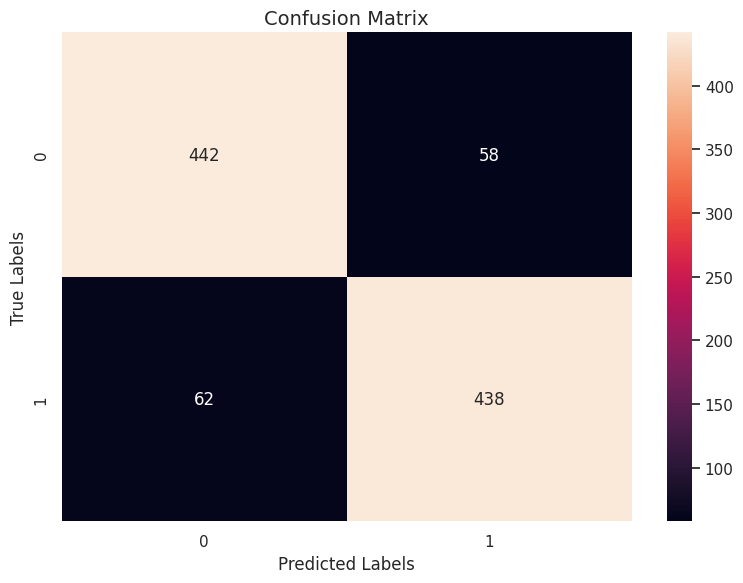

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       500
           1       0.88      0.88      0.88       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

Test Accuracy: 0.88
Test F1 Score: 0.88
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
4 BAAI/bge-m3 - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (1024) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_1019', 'embedding_1020', 'embedding_1021', 'embedding_1022', 'embedding_1023']
X Shape: (7500, 1024) & y Shape

/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_mult


Id   Mean     StDev 					Params
1 0.873538 (0.014913) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 50}
2 0.873538 (0.014913) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 50}
3 0.869538 (0.013087) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 50}
4 0.869538 (0.013087) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'max_iter': 50}
5 0.873692 (0.014955) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 50}
6 0.873692 (0.014955) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 50}
7 0.870000 (0.013239) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'lear

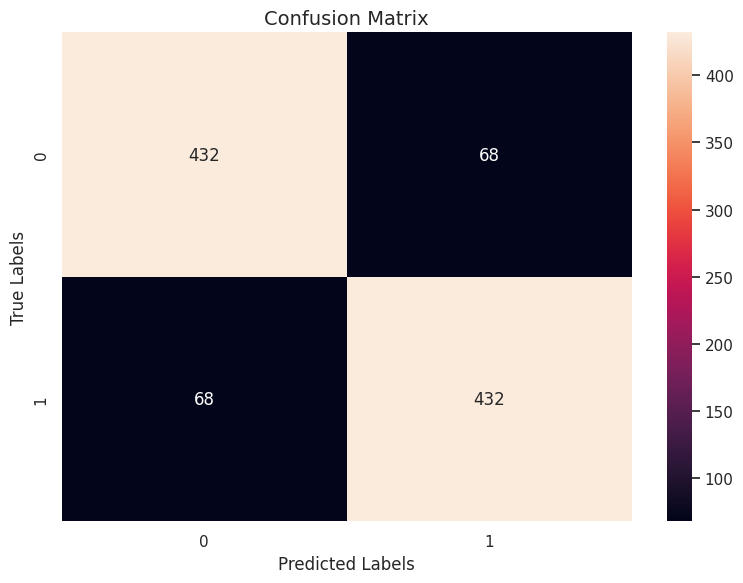

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       500
           1       0.86      0.86      0.86       500

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000

Test Accuracy: 0.864
Test F1 Score: 0.864
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
5 thenlper/gte-large - Embedding Data Shape: (7500, 1026)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Target Unique Values: [1 0]
Feature Columns: (1024) & ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4'] ... ['embedding_1019', 'embedding_1020', 'embedding_1021', 'embedding_1022', 'embedding_1023']
X Shape: (7500, 1024) 

/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/app-root/lib64/python3.9/site-packages/sklearn/neural_network/_mult


Id   Mean     StDev 					Params
1 0.739692 (0.019176) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 50}
2 0.739692 (0.019176) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 50}
3 0.733231 (0.019365) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 50}
4 0.733231 (0.019365) with: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'max_iter': 50}
5 0.740769 (0.018554) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 50}
6 0.740769 (0.018554) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 50}
7 0.732462 (0.019368) with: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'lear

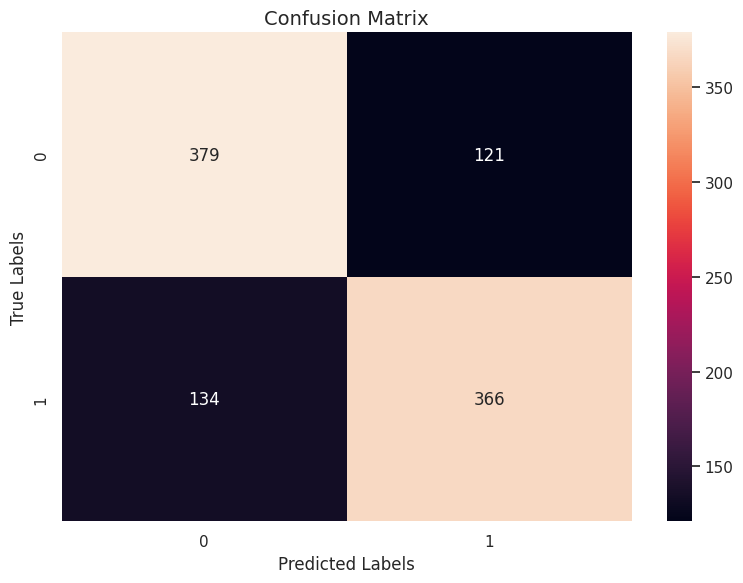

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       500
           1       0.75      0.73      0.74       500

    accuracy                           0.74      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.75      0.74      0.74      1000

Test Accuracy: 0.745
Test F1 Score: 0.745
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
CPU times: user 5min 21s, sys: 17min 12s, total: 22min 33s
Wall time: 2min 54s


In [21]:
%%time

model_stats_mlp = {}

for idx, df_emb_data in enumerate(df_emb_data_list):
    print("# " * 50)
    print(f"{idx+1} {embedding_models[idx]} - Embedding Data Shape: {df_emb_data.shape}")
    print("# " * 50)
    print("Target Unique Values:", df_emb_data['sentiment'].unique())

    feature_columns = [col for col in df_emb_data.columns if 'embedding_' in col]
    print(f"Feature Columns: ({len(feature_columns)}) & {feature_columns[0:5]} ... {feature_columns[len(feature_columns)-5:]}")

    X = df_emb_data[feature_columns].values
    y = df_emb_data['sentiment'].values
    print(f"X Shape: {X.shape} & y Shape: {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
    print(f"X_Train Shape: {X_train.shape} & X_Test Shape: {X_test.shape} & Y_Train Shape: {y_train.shape} & Y_Test Shape: {y_test.shape}")

    X_train.shape, y_train.shape, X_test.shape, y_test.shape

    # Parametre Values for MLP Model
    mlp_param_dist = {
        'hidden_layer_sizes': [(100, ), (100, 50)],
        'activation': ['tanh', 'relu'],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [50],
        'alpha': [0.0001, 0.001],
    }

    # MLP Classifier Model
    mlp_clf = MLPClassifier(random_state=23, max_iter=50)

    # Multilayer Perceptron Model with Random Search
    mlp_random_model = GridSearchCV(mlp_clf, mlp_param_dist, scoring='accuracy', cv=kf, n_jobs=-1)

    mlp_model = mlp_random_model.fit(X_train, y_train)

    mlp_random_model_best_estimator = mlp_model.best_estimator_
    mlp_random_model_best_params = mlp_model.best_params_
    mlp_random_model_best_score = mlp_model.best_score_

    means = mlp_model.cv_results_['mean_test_score']
    stds = mlp_model.cv_results_['std_test_score']
    params = mlp_model.cv_results_['params']

    print()
    print("Id", "  Mean", "    StDev", "\t\t\t\t\tParams")
    for i, (mean, stdev, param) in enumerate(zip(means, stds, params)):
        print("%d %f (%f) with: %r" % (i+1, mean, stdev, param))

    # Summarize Results
    print()
    print("Best: %f using %s" % (mlp_random_model_best_score, mlp_random_model_best_params))
    print()

    y_pred = mlp_random_model_best_estimator.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g');
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

    # Set labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true=y_test, y_pred=y_pred))

    acc_score = round(accuracy_score(y_true=y_test, y_pred=y_pred), 3)
    f1_score_ = round(f1_score(y_true=y_test, y_pred=y_pred, average='macro'), 3)
    print("Test Accuracy:", acc_score)
    print("Test F1 Score:", f1_score_)

    model_stats_mlp[f"Emb_{idx+1}"] = {
        "train_best_score": mlp_random_model_best_score,
        "train_best_params": mlp_random_model_best_params,
        "test_accuracy": acc_score,
        "test_f1": f1_score_,
        "y_test": y_test,
        "y_pred": y_pred,
    }
    print("* " * 50)
    # break

## Result & Conclusion

In [30]:
# Model Stats Serialize

with open(os.path.join(MDL_STATS_PATH, 'hb_model_stats_svm_data.pickle'), 'wb') as handle:
    pickle.dump(model_stats_svm, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(MDL_STATS_PATH, 'hb_model_stats_rf_data.pickle'), 'wb') as handle:
    pickle.dump(model_stats_rf, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open(os.path.join(MDL_STATS_PATH, 'hb_model_stats_mlp_data.pickle'), 'wb') as handle:
#    pickle.dump(model_stats_mlp, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
# Model Stats Deserialize

with open(os.path.join(MDL_STATS_PATH, 'hb_model_stats_svm_data.pickle'), 'rb') as handle:
    model_stats_svm_data = pickle.load(handle)

with open(os.path.join(MDL_STATS_PATH, 'hb_model_stats_rf_data.pickle'), 'rb') as handle:
    model_stats_rf_data = pickle.load(handle)

with open(os.path.join(MDL_STATS_PATH, 'hb_model_stats_mlp_data.pickle'), 'rb') as handle:
    model_stats_mlp_data = pickle.load(handle)

### Performance

In [34]:
for idx, emb in enumerate(embedding_models_dict):
    print(f"Embedding Method: {emb}")
    print(f"\tSVM Model\t: Test Accuracy: {model_stats_svm_data[f'Emb_{idx+1}']['test_accuracy']} & Test F1 Score: {model_stats_svm_data[f'Emb_{idx+1}']['test_f1']}")
    print(f"\tRF Model\t: Test Accuracy: {model_stats_rf_data[f'Emb_{idx+1}']['test_accuracy']} & Test F1 Score: {model_stats_rf_data[f'Emb_{idx+1}']['test_f1']}")
    print(f"\tMLP Model\t: Test Accuracy: {model_stats_mlp_data[f'Emb_{idx+1}']['test_accuracy']} & Test F1 Score: {model_stats_mlp_data[f'Emb_{idx+1}']['test_f1']}")
    print("* " * 35)


Embedding Method: All Mini LM L12 v2
	SVM Model	: Test Accuracy: 0.776 & Test F1 Score: 0.776
	RF Model	: Test Accuracy: 0.72 & Test F1 Score: 0.72
	MLP Model	: Test Accuracy: 0.76 & Test F1 Score: 0.76
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Embedding Method: Jina Embeddings v3
	SVM Model	: Test Accuracy: 0.892 & Test F1 Score: 0.892
	RF Model	: Test Accuracy: 0.872 & Test F1 Score: 0.872
	MLP Model	: Test Accuracy: 0.887 & Test F1 Score: 0.887
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Embedding Method: Int Float Multilingual E5 Large Instruct
	SVM Model	: Test Accuracy: 0.893 & Test F1 Score: 0.893
	RF Model	: Test Accuracy: 0.881 & Test F1 Score: 0.881
	MLP Model	: Test Accuracy: 0.88 & Test F1 Score: 0.88
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Embedding Method: BAAI BGE M3
	SVM Model	: Test Accuracy: 0.883 & Test F1 Score: 0.883
	RF Model	: Test Accuracy: 0.872 & Test F1 Score: 0.872
	MLP Mo

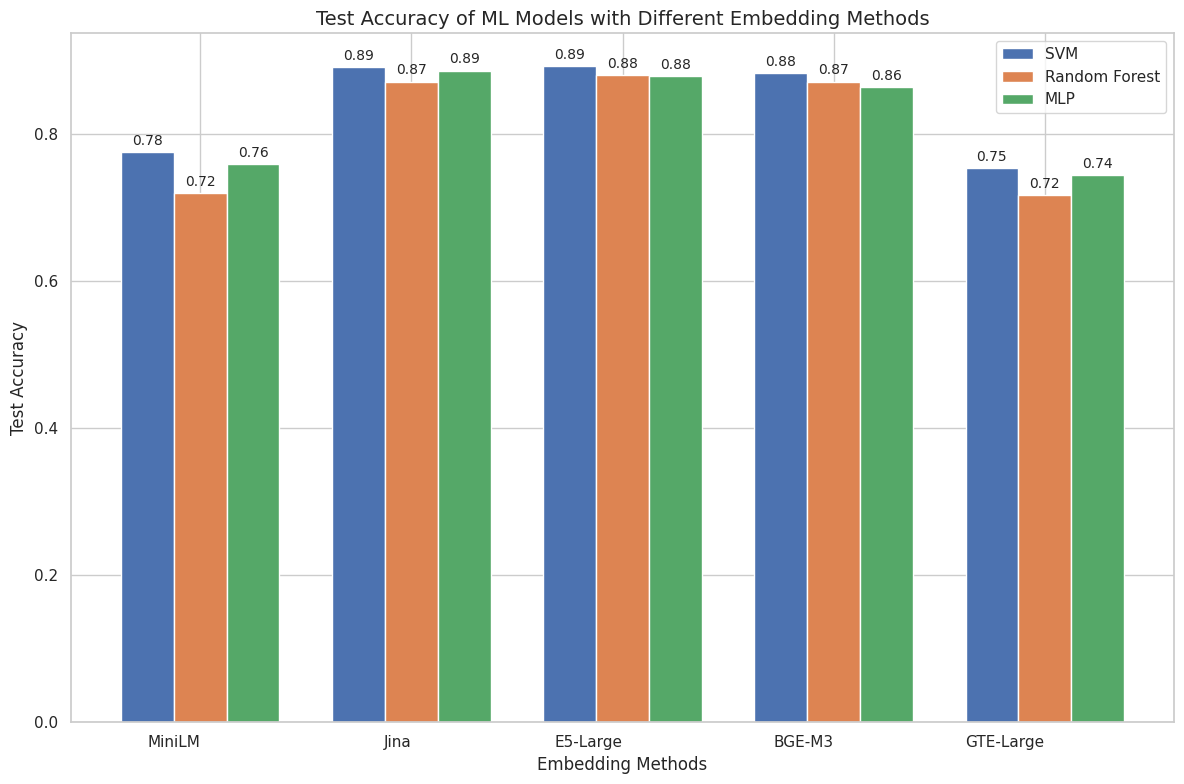

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Extract embedding method names
embedding_methods_graph = ['MiniLM', 'Jina', 'E5-Large', 'BGE-M3', 'GTE-Large']

# Extracting test accuracy for each model from pickle-loaded data
svm_accuracies = [model_stats_svm_data[f'Emb_{idx+1}']['test_accuracy'] for idx in range(len(embedding_methods_graph))]
rf_accuracies = [model_stats_rf_data[f'Emb_{idx+1}']['test_accuracy'] for idx in range(len(embedding_methods_graph))]
mlp_accuracies = [model_stats_mlp_data[f'Emb_{idx+1}']['test_accuracy'] for idx in range(len(embedding_methods_graph))]

# Setting up the bar chart
x = np.arange(len(embedding_methods_graph))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Bars for each model
rects1 = ax.bar(x - width, svm_accuracies, width, label='SVM')
rects2 = ax.bar(x, rf_accuracies, width, label='Random Forest')
rects3 = ax.bar(x + width, mlp_accuracies, width, label='MLP')

# Add labels, title, and legend
ax.set_xlabel('Embedding Methods', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Test Accuracy of ML Models with Different Embedding Methods', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(embedding_methods_graph, ha='right')
ax.legend()

# Add accuracy values above bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

fig.tight_layout()
plt.show()


### Aynı Temsil Yöntemi (5)


In [35]:
df_same_emb_all_model = pd.DataFrame()

for idx, emb in enumerate(embedding_models_dict):
    # print(f"Embedding Method: {emb}")
    # Y Test Real
    # array0 = y_test
    # array0 = np.insert(array0.astype(object), 0, "-")
    # array0 = np.insert(array0.astype(object), 1, "-")
    # array0 = np.insert(array0.astype(object), 2, "YReal")

    # Y Pred
    array1 = model_stats_svm_data[f"Emb_{idx+1}"]["y_pred"]
    array1 = np.insert(array1.astype(object), 0, f"{emb}")
    array1 = np.insert(array1.astype(object), 1, "SVM")
    array1 = np.insert(array1.astype(object), 2, "YPred")

    # Y Pred
    array2 = model_stats_rf_data[f"Emb_{idx+1}"]["y_pred"]
    array2 = np.insert(array2.astype(object), 0, f"{emb}")
    array2 = np.insert(array2.astype(object), 1, "RF")
    array2 = np.insert(array2.astype(object), 2, "YPred")

    # Y Pred
    array3 = model_stats_mlp_data[f"Emb_{idx+1}"]["y_pred"]
    array3 = np.insert(array3.astype(object), 0, f"{emb}")
    array3 = np.insert(array3.astype(object), 1, "MLP")
    array3 = np.insert(array3.astype(object), 2, "YPred")

    # df_same_emb_all_model_tmp = pd.DataFrame([array0, array1, array2, array3])
    df_same_emb_all_model_tmp = pd.DataFrame([array1, array2, array3])
    df_same_emb_all_model = pd.concat([df_same_emb_all_model, df_same_emb_all_model_tmp])

df_same_emb_all_model.rename(columns={0:"EmbeddingMethod", 1:"Model", 2:"Y_Real/Test"}, inplace=True)
df_same_emb_all_model.reset_index(drop=True, inplace=True)
df_same_emb_all_model

EmbeddingMethod Model Y_Real/Test  3  4  5  6  7  \
0                         All Mini LM L12 v2   SVM       YPred  1  0  1  1  1   
1                         All Mini LM L12 v2    RF       YPred  1  0  1  1  1   
2                         All Mini LM L12 v2   MLP       YPred  1  0  1  1  1   
3                         Jina Embeddings v3   SVM       YPred  1  0  0  0  1   
4                         Jina Embeddings v3    RF       YPred  1  0  0  0  1   
5                         Jina Embeddings v3   MLP       YPred  1  0  0  0  1   
6   Int Float Multilingual E5 Large Instruct   SVM       YPred  1  0  0  0  1   
7   Int Float Multilingual E5 Large Instruct    RF       YPred  1  0  0  0  1   
8   Int Float Multilingual E5 Large Instruct   MLP       YPred  1  0  0  0  1   
9                                BAAI BGE M3   SVM       YPred  1  0  0  0  1   
10                               BAAI BGE M3    RF       YPred  1  0  0  0  1   
11                               BAAI BGE M3   MLP       YPred  1  0  0  0  1   
12                        Thenlper Gte Large   SVM       YPred  1  0  1  1  1   
13                        Thenlper Gte Large    RF       YPred  1  0  0  0  1   
14                        Thenlper Gte Large   MLP       YPred  1  0  1  1  1   

    8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  \
0   0  1   0   0   1   1   1   1   1   0   1   1   1   1   1   1   1   0   1   
1   0  1   0   0   1   1   1   1   1   0   0   1   1   1   1   0   1   0   1   
2   1  1   0   0   1   1   1   1   1   0   1   1   1   1   1   1   1   0   1   
3   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
4   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
5   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
6   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
7   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   1   
8   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
9   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
10  1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
11  1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   1   
12  0  1   0   0   1   1   1   1   1   0   0   1   0   1   1   0   1   0   1   
13  0  1   0   0   1   0   1   1   1   0   0   1   1   1   1   0   1   0   1   
14  0  1   0   0   1   1   1   1   1   0   0   1   1   1   1   0   1   0   1   

    27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  \
0    1   1   0   0   0   1   1   1   0   0   1   0   0   0   0   1   0   1   
1    1   1   0   0   0   1   0   1   0   0   0   0   0   0   0   1   0   1   
2    1   1   0   0   0   1   1   1   0   0   1   0   1   0   0   1   0   1   
3    1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
4    1   1   0   0   0   1   1   1   0   0   1   0   1   0   0   1   0   1   
5    1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
6    1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
7    1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
8    1   1   0   0   0   1   0   1   0   0   1   0   1   1   0   1   0   1   
9    1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
10   1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
11   1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
12   1   1   1   0   0   1   1   1   0   0   1   0   1   0   0   1   0   1   
13   1   0   0   0   0   1   1   1   0   0   1   0   0   0   0   1   0   1   
14   1   1   1   0   0   1   1   1   0   0   1   0   1   0   0   1   0   1   

    45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
0    1   0   0   0   0   1   1   0   1   0   1   0   1   0   1   0   0   0   
1    1   0   0   0   0   1   1   1   0   0   0

#### All Mini LM L12 v2

In [36]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="All Mini LM L12 v2") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  \
0      1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   1   1   1   1   
1      1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   0   1   1   1   
2      1  0  1  1  1  1  1   0   0   1   1   1   1   1   0   1   1   1   1   
Mode   1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   1   1   1   1   
YReal  1  0  0  1  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   

       22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
0       1   1   1   0   1   1   1   0   0   0   1   1   1   0   0   1   0   0   
1       1   0   1   0   1   1   1   0   0   0   1   0   1   0   0   0   0   0   
2       1   1   1   0   1   1   1   0   0   0   1   1   1   0   0   1   0   1   
Mode    1   1   1   0   1   1   1   0   0   0   1   1   1   0   0   1   0   0   
YReal   1   1   1   0   1   1   1   0   0   1   1   0   1   0   0   1   0   1   

       40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  \
0       0   0   1   0   1   1   0   0   0   0   1   1   0   1   0   1   0   1   
1       0   0   1   0   1   1   0   0   0   0   1   1   1   0   0   0   0   1   
2       0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   1   
Mode    0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   1   
YReal   1   0   1   0   1   1   0   1   0   0   0   1   0   1   0   1   1   0   

       58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  \
0       0   1   0   0   0   1   1   1   1   1   1   0   0   1   0   0   0   0   
1       0   1   0   0   0   1   0   1   1   1   1   0   0   1   0   0   0   1   
2       0   1   0   0   0   1   1   1   1   1   1   0   0   1   0   0   1   0   
Mode    0   1   0   0   0   1   1   1   1   1   1   0   0   1   0   0   0   0   
YReal   0   0   0   1   0   1   1   1   1   1   1   0   1   1   0   0   1   1   

       76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
0       0   0   0   0   0   1   0   0   0   0   0   1   1   0   0   1   0   1   
1       0   0   0   0   0   1   0   1   0   0   0   1   0   0   1   1   0   0   
2       0   0   0   0   0   1   0   1   0   0   0   1   1   0   1   1   1   0   
Mode    0   0   0   0   0   1   0   1   0   0   0   1   1   0   1   1   0   0   
YReal   0   0   0   0   0   1   0   0   0   0   1   0   1   0   0   1   0   1   

       94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  \
0       1   1   0   0   1   0    1    0    1    0    1    0    1    0    0   
1       1   1   0   0   1   1    1    0    1    0    1    0    1    0    0   
2       1   1   0   0   1   1    1    0    1    0    1    0    1    1    0   
Mode    1   1   0   0   1   1    1    0    1    0    1    0    1    0    0   
YReal   1   0   0   0   0   0    1    0    1    0    0    0    1    0    0   

       109  110  111  112  113  114  115  116  117  118  119  120  121  122  \
0        0    1    0    0    1    0    0    0    0    0    0    1    0    0   
1        0    1    0    1    1    1    0    0    0    0    0    1    0    0   
2        0    1    0    0    1    1    0    0    1    0    1    1    0    0   
Mode     0    1    0    0    1    1    0    0    0    0    0    1    0    0   
YReal    0    1    0    1    1    1    0    0    1    1    0    1    1    0   

       123  124  125  126  127  128  129  130  131  132  133  134  135  136  \
0        1    0    1    1    1    1    0    0    1    1    1    0    1    0   
1        1    0    1    0    1    1    0    0    1    1    1    0    1    0   
2        1    0    1    1    1    1    0    0    1    1    1    0    1    0   
Mode     1    0    1    1    1    1    0    0    1    1    1    0    1    0   
YReal    1    0    0    1    0    1    0    0    1    1    0    0    1    0   

       137  138  139  140  141  142  143  144  145  146  147  148  149  150  \
0        0    1    1    0    1    0    0    1    1    0    0    0    0    0   
1        0   

In [37]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2}")

Doğruluk Oranı: 0.78


#### Jina Embeddings v3

In [38]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="Jina Embeddings v3") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  \
3      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
4      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
5      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
Mode   1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
YReal  1  0  0  1  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   

       22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
3       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
4       1   1   1   0   0   1   1   0   0   0   1   1   1   0   0   1   0   1   
5       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
Mode    1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
YReal   1   1   1   0   1   1   1   0   0   1   1   0   1   0   0   1   0   1   

       40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  \
3       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
4       0   0   1   0   1   1   0   1   0   0   1   1   1   1   0   1   1   0   
5       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
Mode    0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
YReal   1   0   1   0   1   1   0   1   0   0   0   1   0   1   0   1   1   0   

       58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  \
3       0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   1   
4       0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   0   0   1   
5       0   1   0   0   0   1   1   1   1   1   1   0   0   1   0   1   0   1   
Mode    0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   1   
YReal   0   0   0   1   0   1   1   1   1   1   1   0   1   1   0   0   1   1   

       76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
3       0   0   0   0   0   1   0   0   0   0   1   0   1   1   1   0   0   1   
4       0   0   0   0   0   1   0   0   0   0   1   0   1   0   1   1   0   0   
5       0   0   0   0   0   1   0   0   0   0   1   0   1   1   1   0   0   1   
Mode    0   0   0   0   0   1   0   0   0   0   1   0   1   1   1   0   0   1   
YReal   0   0   0   0   0   1   0   0   0   0   1   0   1   0   0   1   0   1   

       94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  \
3       1   0   0   0   1   1    1    0    1    0    0    0    1    0    0   
4       1   0   0   0   1   1    1    0    1    0    0    0    0    0    0   
5       1   0   0   0   1   1    1    0    1    0    0    0    0    0    0   
Mode    1   0   0   0   1   1    1    0    1    0    0    0    0    0    0   
YReal   1   0   0   0   0   0    1    0    1    0    0    0    1    0    0   

       109  110  111  112  113  114  115  116  117  118  119  120  121  122  \
3        0    0    0    1    1    1    0    0    1    1    0    0    1    0   
4        0    0    0    1    1    1    0    0    1    1    0    1    0    0   
5        0    0    0    1    1    1    0    0    1    1    0    0    1    0   
Mode     0    0    0    1    1    1    0    0    1    1    0    0    1    0   
YReal    0    1    0    1    1    1    0    0    1    1    0    1    1    0   

       123  124  125  126  127  128  129  130  131  132  133  134  135  136  \
3        1    0    0    1    0    1    0    0    1    1    1    0    1    0   
4        1    0    1    1    0    1    0    0    1    1    0    0    1    0   
5        1    0    0    1    0    1    0    0    1    1    0    0    1    0   
Mode     1    0    0    1    0    1    0    0    1    1    0    0    1    0   
YReal    1    0    0    1    0    1    0    0    1    1    0    0    1    0   

       137  138  139  140  141  142  143  144  145  146  147  148  149  150  \
3        0    1    1    0    1    0    1    1    1    0    0    1    0    1   
4        0   

In [39]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2}")

Doğruluk Oranı: 0.89


#### Int Float Multilingual E5 Large Instruct

In [40]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="Int Float Multilingual E5 Large Instruct") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  \
6      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
7      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
8      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
Mode   1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
YReal  1  0  0  1  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   

       22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
6       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
7       1   1   1   0   1   1   1   0   0   0   1   0   1   0   0   1   0   1   
8       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
Mode    1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
YReal   1   1   1   0   1   1   1   0   0   1   1   0   1   0   0   1   0   1   

       40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  \
6       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
7       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
8       1   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
Mode    0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
YReal   1   0   1   0   1   1   0   1   0   0   0   1   0   1   0   1   1   0   

       58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  \
6       0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   0   
7       0   0   0   0   0   1   1   1   1   1   1   0   1   0   0   1   0   0   
8       0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   0   
Mode    0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   0   
YReal   0   0   0   1   0   1   1   1   1   1   1   0   1   1   0   0   1   1   

       76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
6       0   0   0   0   0   1   0   0   0   0   0   0   1   1   0   1   0   1   
7       0   0   0   0   0   1   0   0   0   0   0   0   1   1   1   1   0   1   
8       0   0   0   0   0   1   0   0   0   0   0   0   1   1   0   1   0   1   
Mode    0   0   0   0   0   1   0   0   0   0   0   0   1   1   0   1   0   1   
YReal   0   0   0   0   0   1   0   0   0   0   1   0   1   0   0   1   0   1   

       94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  \
6       1   0   0   0   1   1    1    0    1    1    0    0    0    0    0   
7       1   0   0   0   1   1    1    0    1    1    0    0    0    0    0   
8       1   0   0   0   1   1    1    0    1    1    0    0    0    0    0   
Mode    1   0   0   0   1   1    1    0    1    1    0    0    0    0    0   
YReal   1   0   0   0   0   0    1    0    1    0    0    0    1    0    0   

       109  110  111  112  113  114  115  116  117  118  119  120  121  122  \
6        0    1    0    1    1    1    0    0    1    1    0    1    1    0   
7        0    1    0    1    1    1    0    0    1    1    0    1    1    0   
8        0    0    0    1    1    1    0    0    1    1    0    0    0    0   
Mode     0    1    0    1    1    1    0    0    1    1    0    1    1    0   
YReal    0    1    0    1    1    1    0    0    1    1    0    1    1    0   

       123  124  125  126  127  128  129  130  131  132  133  134  135  136  \
6        1    0    0    1    0    1    0    0    1    1    0    0    1    0   
7        1    0    0    1    0    1    0    0    1    1    0    0    1    0   
8        1    0    0    1    0    1    0    0    1    1    0    0    1    0   
Mode     1    0    0    1    0    1    0    0    1    1    0    0    1    0   
YReal    1    0    0    1    0    1    0    0    1    1    0    0    1    0   

       137  138  139  140  141  142  143  144  145  146  147  148  149  150  \
6        0    1    1    0    1    0    1    1    1    0    1    1    0    1   
7        0   

In [41]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2}")

Doğruluk Oranı: 0.89


#### BAAI BGE M

In [42]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="BAAI BGE M3") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  \
9      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
10     1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
11     1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
Mode   1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
YReal  1  0  0  1  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   

       22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
9       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
10      1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
11      1   1   1   0   1   1   1   0   0   0   1   0   1   0   0   1   0   1   
Mode    1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
YReal   1   1   1   0   1   1   1   0   0   1   1   0   1   0   0   1   0   1   

       40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  \
9       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
10      0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   1   0   
11      0   0   1   0   1   1   0   1   0   0   1   1   1   1   0   1   1   0   
Mode    0   0   1   0   1   1   0   1   0   0   1   1   1   1   0   1   1   0   
YReal   1   0   1   0   1   1   0   1   0   0   0   1   0   1   0   1   1   0   

       58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  \
9       0   0   0   0   0   1   1   1   1   1   1   0   0   1   0   1   0   1   
10      0   0   0   0   0   1   1   1   1   1   1   0   0   1   0   0   0   1   
11      0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   1   
Mode    0   0   0   0   0   1   1   1   1   1   1   0   0   1   0   1   0   1   
YReal   0   0   0   1   0   1   1   1   1   1   1   0   1   1   0   0   1   1   

       76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
9       0   0   0   0   0   1   0   0   0   0   1   0   1   0   1   0   0   1   
10      1   0   0   0   0   1   0   0   0   0   0   0   1   1   1   0   0   0   
11      1   0   0   0   0   1   0   0   0   0   0   0   1   0   1   1   0   0   
Mode    1   0   0   0   0   1   0   0   0   0   0   0   1   0   1   0   0   0   
YReal   0   0   0   0   0   1   0   0   0   0   1   0   1   0   0   1   0   1   

       94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  \
9       1   0   0   0   1   1    1    0    1    1    0    0    0    0    0   
10      1   0   0   0   1   1    1    0    1    1    0    0    0    0    0   
11      1   0   0   0   1   1    1    0    1    1    0    0    1    0    0   
Mode    1   0   0   0   1   1    1    0    1    1    0    0    0    0    0   
YReal   1   0   0   0   0   0    1    0    1    0    0    0    1    0    0   

       109  110  111  112  113  114  115  116  117  118  119  120  121  122  \
9        0    0    0    1    1    1    0    0    1    1    0    0    1    0   
10       0    0    0    1    1    1    0    0    1    1    0    1    0    0   
11       0    0    0    1    1    1    0    0    1    1    0    0    0    0   
Mode     0    0    0    1    1    1    0    0    1    1    0    0    0    0   
YReal    0    1    0    1    1    1    0    0    1    1    0    1    1    0   

       123  124  125  126  127  128  129  130  131  132  133  134  135  136  \
9        1    0    1    1    0    1    0    0    1    1    0    0    1    0   
10       1    0    1    1    0    1    0    0    1    1    0    0    1    0   
11       1    0    1    1    0    1    0    0    1    1    0    0    1    0   
Mode     1    0    1    1    0    1    0    0    1    1    0    0    1    0   
YReal    1    0    0    1    0    1    0    0    1    1    0    0    1    0   

       137  138  139  140  141  142  143  144  145  146  147  148  149  150  \
9        0    1    1    0    1    0    1    1    1    0    1    1    0    1   
10       0   

In [43]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.2}")

Doğruluk Oranı: 0.87


#### Thenlper Gte Large

In [44]:
df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']=="Thenlper Gte Large") & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  \
12     1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   0   1   0   1   
13     1  0  0  0  1  0  1   0   0   1   0   1   1   1   0   0   1   1   1   
14     1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   0   1   1   1   
Mode   1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   0   1   1   1   
YReal  1  0  0  1  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   

       22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
12      1   0   1   0   1   1   1   1   0   0   1   1   1   0   0   1   0   1   
13      1   0   1   0   1   1   0   0   0   0   1   1   1   0   0   1   0   0   
14      1   0   1   0   1   1   1   1   0   0   1   1   1   0   0   1   0   1   
Mode    1   0   1   0   1   1   1   1   0   0   1   1   1   0   0   1   0   1   
YReal   1   1   1   0   1   1   1   0   0   1   1   0   1   0   0   1   0   1   

       40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  \
12      0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   1   
13      0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   0   
14      0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   1   
Mode    0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   1   
YReal   1   0   1   0   1   1   0   1   0   0   0   1   0   1   0   1   1   0   

       58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  \
12      0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   0   
13      0   0   0   0   0   1   1   1   1   1   1   0   0   1   0   0   0   0   
14      0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   1   
Mode    0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   0   
YReal   0   0   0   1   0   1   1   1   1   1   1   0   1   1   0   0   1   1   

       76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
12      0   0   0   0   0   1   0   1   0   0   0   1   1   0   1   1   0   0   
13      0   0   0   0   0   1   0   1   0   0   0   1   0   0   1   1   0   0   
14      0   0   0   0   0   1   0   1   0   0   0   1   1   1   1   1   1   0   
Mode    0   0   0   0   0   1   0   1   0   0   0   1   1   0   1   1   0   0   
YReal   0   0   0   0   0   1   0   0   0   0   1   0   1   0   0   1   0   1   

       94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  \
12      1   1   0   0   0   1    1    0    1    0    1    0    1    0    0   
13      1   0   0   0   1   1    1    0    1    0    1    0    0    1    0   
14      1   1   0   0   0   1    1    0    1    0    0    0    1    0    0   
Mode    1   1   0   0   0   1    1    0    1    0    1    0    1    0    0   
YReal   1   0   0   0   0   0    1    0    1    0    0    0    1    0    0   

       109  110  111  112  113  114  115  116  117  118  119  120  121  122  \
12       0    1    0    1    1    1    0    0    1    1    0    1    0    0   
13       0    1    0    1    1    1    0    0    0    1    0    1    0    0   
14       0    1    0    1    1    1    0    0    1    1    0    1    0    0   
Mode     0    1    0    1    1    1    0    0    1    1    0    1    0    0   
YReal    0    1    0    1    1    1    0    0    1    1    0    1    1    0   

       123  124  125  126  127  128  129  130  131  132  133  134  135  136  \
12       1    0    1    0    1    1    0    0    1    1    1    0    1    0   
13       1    0    1    1    1    1    0    0    1    1    1    0    1    0   
14       1    1    1    1    1    1    0    0    1    1    1    0    1    0   
Mode     1    0    1    1    1    1    0    0    1    1    1    0    1    0   
YReal    1    0    0    1    0    1    0    0    1    1    0    0    1    0   

       137  138  139  140  141  142  143  144  145  146  147  148  149  150  \
12       1    1    1    0    1    0    1    1    0    0    0    0    0    0   
13       1   

In [45]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions
print(f"Doğruluk Oranı: {accuracy:.2}")

Doğruluk Oranı: 0.75


#### All Embedding Method Result

In [46]:
for idx, emb in enumerate(embedding_models_dict):
    # print(f"Embedding Method: {emb}")
    df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod']==emb) & (df_same_emb_all_model['Y_Real/Test']=="YPred")].iloc[:, 3:]
    modes = df.mode().iloc[0]
    df.loc["Mode"] = modes
    df.loc["YReal"] = y_test
    # df

    correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
    total_predictions = df.shape[1]
    accuracy = correct_predictions / total_predictions

    print(f"{idx+1}. Embedding Method: {emb:<40} \t\t\t Doğruluk Oranı: {accuracy:.3}")

1. Embedding Method: All Mini LM L12 v2                       			 Doğruluk Oranı: 0.775
2. Embedding Method: Jina Embeddings v3                       			 Doğruluk Oranı: 0.892
3. Embedding Method: Int Float Multilingual E5 Large Instruct 			 Doğruluk Oranı: 0.889
4. Embedding Method: BAAI BGE M3                              			 Doğruluk Oranı: 0.872
5. Embedding Method: Thenlper Gte Large                       			 Doğruluk Oranı: 0.753


#### Embedding x Models vs Ensemble Result (!)

In [51]:
for idx, emb in enumerate(embedding_models_dict):
    print(f"Embedding Method: {emb}")
    print(f"\tSVM Model\t: Test Accuracy: {model_stats_svm_data[f'Emb_{idx+1}']['test_accuracy']} & Test F1 Score: {model_stats_svm_data[f'Emb_{idx+1}']['test_f1']}")
    print(f"\tRF Model\t: Test Accuracy: {model_stats_rf_data[f'Emb_{idx+1}']['test_accuracy']} & Test F1 Score: {model_stats_rf_data[f'Emb_{idx+1}']['test_f1']}")
    print(f"\tMLP Model\t: Test Accuracy: {model_stats_mlp_data[f'Emb_{idx+1}']['test_accuracy']} & Test F1 Score: {model_stats_mlp_data[f'Emb_{idx+1}']['test_f1']}")

    df = df_same_emb_all_model[(df_same_emb_all_model['EmbeddingMethod'] == emb) & (df_same_emb_all_model['Y_Real/Test'] == "YPred")].iloc[:, 3:]
    modes = df.mode().iloc[0]
    df.loc["Mode"] = modes
    df.loc["YReal"] = y_test

    correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
    total_predictions = df.shape[1]
    accuracy = correct_predictions / total_predictions

    print(f"\tEnsemble Model\t: Test Accuracy: {accuracy:.3}")
    print("* " * 35)


Embedding Method: All Mini LM L12 v2
	SVM Model	: Test Accuracy: 0.776 & Test F1 Score: 0.776
	RF Model	: Test Accuracy: 0.72 & Test F1 Score: 0.72
	MLP Model	: Test Accuracy: 0.76 & Test F1 Score: 0.76
	Ensemble Model	: Test Accuracy: 0.775
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Embedding Method: Jina Embeddings v3
	SVM Model	: Test Accuracy: 0.892 & Test F1 Score: 0.892
	RF Model	: Test Accuracy: 0.872 & Test F1 Score: 0.872
	MLP Model	: Test Accuracy: 0.887 & Test F1 Score: 0.887
	Ensemble Model	: Test Accuracy: 0.892
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Embedding Method: Int Float Multilingual E5 Large Instruct
	SVM Model	: Test Accuracy: 0.893 & Test F1 Score: 0.893
	RF Model	: Test Accuracy: 0.881 & Test F1 Score: 0.881
	MLP Model	: Test Accuracy: 0.88 & Test F1 Score: 0.88
	Ensemble Model	: Test Accuracy: 0.889
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Embedding Method: BAAI BGE M3
	SV

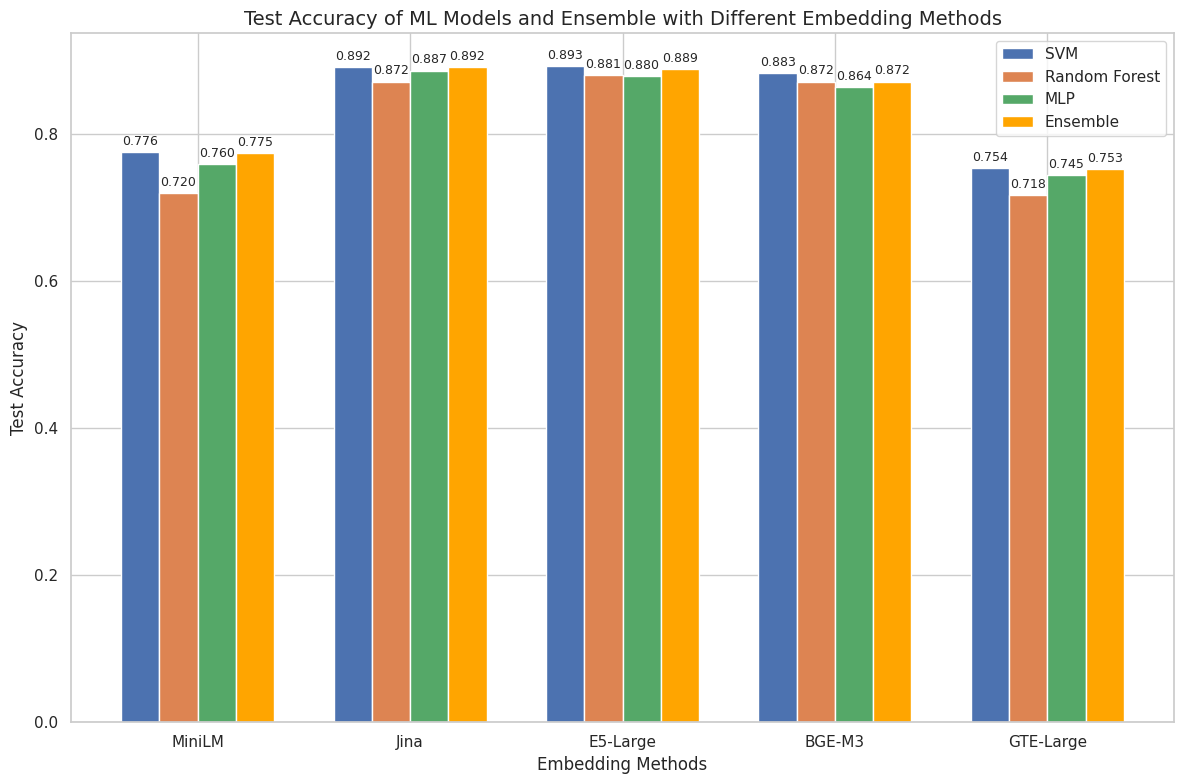

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Extract embedding method names
embedding_methods_graph = ['MiniLM', 'Jina', 'E5-Large', 'BGE-M3', 'GTE-Large']

# Extracting test accuracy for each model from pickle-loaded data
svm_accuracies = [model_stats_svm_data[f'Emb_{idx+1}']['test_accuracy'] for idx in range(len(embedding_methods_graph))]
rf_accuracies = [model_stats_rf_data[f'Emb_{idx+1}']['test_accuracy'] for idx in range(len(embedding_methods_graph))]
mlp_accuracies = [model_stats_mlp_data[f'Emb_{idx+1}']['test_accuracy'] for idx in range(len(embedding_methods_graph))]

# Extract ensemble accuracies for each embedding method
ensemble_accuracies = []

for idx, emb in enumerate(embedding_models_dict):
    # Filtering DataFrame for the current embedding method and calculating ensemble accuracy
    df = df_same_emb_all_model[
        (df_same_emb_all_model['EmbeddingMethod'] == emb) &
        (df_same_emb_all_model['Y_Real/Test'] == "YPred")
    ].iloc[:, 3:]
    modes = df.mode().iloc[0]
    df.loc["Mode"] = modes
    df.loc["YReal"] = y_test

    correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
    total_predictions = df.shape[1]
    accuracy = correct_predictions / total_predictions
    ensemble_accuracies.append(round(accuracy, 3))


# Setting up the bar chart
x = np.arange(len(embedding_methods_graph))  # Label locations
width = 0.18  # Adjusted width to fit 4 bars

fig, ax = plt.subplots(figsize=(12, 8))

# Bars for each model
rects1 = ax.bar(x - 1.5*width, svm_accuracies, width, label='SVM')
rects2 = ax.bar(x - 0.5*width, rf_accuracies, width, label='Random Forest')
rects3 = ax.bar(x + 0.5*width, mlp_accuracies, width, label='MLP')
rects4 = ax.bar(x + 1.5*width, ensemble_accuracies, width, label='Ensemble', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Embedding Methods', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Test Accuracy of ML Models and Ensemble with Different Embedding Methods', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(embedding_methods_graph, ha='center')
ax.legend()

# Add accuracy values above bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

fig.tight_layout()
plt.show()


### Aynı Algoritma (3)

In [52]:
df_same_mdl_all_emb = pd.DataFrame()

for mdl in ["SVM", "RF", "MLP"]:
    if mdl == "SVM":
        model_stats_mdl_data = model_stats_svm_data
    elif mdl == "RF":
        model_stats_mdl_data = model_stats_rf_data
    else:
        model_stats_mdl_data = model_stats_mlp_data

    for idx, emb in enumerate(embedding_models_dict):
        array1 = model_stats_mdl_data[f"Emb_{idx+1}"]["y_pred"]
        array1 = np.insert(array1.astype(object), 0, f"{mdl}")
        array1 = np.insert(array1.astype(object), 1, f"{emb}")
        array1 = np.insert(array1.astype(object), 2, "YPred")
        df_same_mdl_all_emb_tmp = pd.DataFrame([array1])
        df_same_mdl_all_emb = pd.concat([df_same_mdl_all_emb, df_same_mdl_all_emb_tmp])

df_same_mdl_all_emb.rename(columns={0:"Model", 1:"EmbeddingMethod", 2:"Y_Real/Test"}, inplace=True)
df_same_mdl_all_emb.reset_index(drop=True, inplace=True)
df_same_mdl_all_emb

Model                           EmbeddingMethod Y_Real/Test  3  4  5  6  7  \
0    SVM                        All Mini LM L12 v2       YPred  1  0  1  1  1   
1    SVM                        Jina Embeddings v3       YPred  1  0  0  0  1   
2    SVM  Int Float Multilingual E5 Large Instruct       YPred  1  0  0  0  1   
3    SVM                               BAAI BGE M3       YPred  1  0  0  0  1   
4    SVM                        Thenlper Gte Large       YPred  1  0  1  1  1   
5     RF                        All Mini LM L12 v2       YPred  1  0  1  1  1   
6     RF                        Jina Embeddings v3       YPred  1  0  0  0  1   
7     RF  Int Float Multilingual E5 Large Instruct       YPred  1  0  0  0  1   
8     RF                               BAAI BGE M3       YPred  1  0  0  0  1   
9     RF                        Thenlper Gte Large       YPred  1  0  0  0  1   
10   MLP                        All Mini LM L12 v2       YPred  1  0  1  1  1   
11   MLP                        Jina Embeddings v3       YPred  1  0  0  0  1   
12   MLP  Int Float Multilingual E5 Large Instruct       YPred  1  0  0  0  1   
13   MLP                               BAAI BGE M3       YPred  1  0  0  0  1   
14   MLP                        Thenlper Gte Large       YPred  1  0  1  1  1   

    8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  \
0   0  1   0   0   1   1   1   1   1   0   1   1   1   1   1   1   1   0   1   
1   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
2   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
3   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
4   0  1   0   0   1   1   1   1   1   0   0   1   0   1   1   0   1   0   1   
5   0  1   0   0   1   1   1   1   1   0   0   1   1   1   1   0   1   0   1   
6   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
7   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   1   
8   1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
9   0  1   0   0   1   0   1   1   1   0   0   1   1   1   1   0   1   0   1   
10  1  1   0   0   1   1   1   1   1   0   1   1   1   1   1   1   1   0   1   
11  1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
12  1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   0   
13  1  1   0   0   1   1   1   1   1   0   0   1   1   1   1   1   1   0   1   
14  0  1   0   0   1   1   1   1   1   0   0   1   1   1   1   0   1   0   1   

    27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  \
0    1   1   0   0   0   1   1   1   0   0   1   0   0   0   0   1   0   1   
1    1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
2    1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
3    1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
4    1   1   1   0   0   1   1   1   0   0   1   0   1   0   0   1   0   1   
5    1   1   0   0   0   1   0   1   0   0   0   0   0   0   0   1   0   1   
6    1   1   0   0   0   1   1   1   0   0   1   0   1   0   0   1   0   1   
7    1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
8    1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
9    1   0   0   0   0   1   1   1   0   0   1   0   0   0   0   1   0   1   
10   1   1   0   0   0   1   1   1   0   0   1   0   1   0   0   1   0   1   
11   1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
12   1   1   0   0   0   1   0   1   0   0   1   0   1   1   0   1   0   1   
13   1   1   0   0   0   1   0   1   0   0   1   0   1   0   0   1   0   1   
14   1   1   1   0   0   1   1   1   0   0   1   0   1   0   0   1   0   1   

    45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  \
0    1   0   0   0   0   1   1   0   1   0   1   0   1   0   1   0   0   0   
1    1   0   1   0  

#### SVM Model

In [53]:
df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']=="SVM") & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  \
0      1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   1   1   1   1   
1      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
2      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
3      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
4      1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   0   1   0   1   
Mode   1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
YReal  1  0  0  1  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   

       22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
0       1   1   1   0   1   1   1   0   0   0   1   1   1   0   0   1   0   0   
1       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
2       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
3       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
4       1   0   1   0   1   1   1   1   0   0   1   1   1   0   0   1   0   1   
Mode    1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
YReal   1   1   1   0   1   1   1   0   0   1   1   0   1   0   0   1   0   1   

       40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  \
0       0   0   1   0   1   1   0   0   0   0   1   1   0   1   0   1   0   1   
1       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
2       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
3       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
4       0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   1   
Mode    0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
YReal   1   0   1   0   1   1   0   1   0   0   0   1   0   1   0   1   1   0   

       58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  \
0       0   1   0   0   0   1   1   1   1   1   1   0   0   1   0   0   0   0   
1       0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   1   
2       0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   0   
3       0   0   0   0   0   1   1   1   1   1   1   0   0   1   0   1   0   1   
4       0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   0   
Mode    0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   0   
YReal   0   0   0   1   0   1   1   1   1   1   1   0   1   1   0   0   1   1   

       76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
0       0   0   0   0   0   1   0   0   0   0   0   1   1   0   0   1   0   1   
1       0   0   0   0   0   1   0   0   0   0   1   0   1   1   1   0   0   1   
2       0   0   0   0   0   1   0   0   0   0   0   0   1   1   0   1   0   1   
3       0   0   0   0   0   1   0   0   0   0   1   0   1   0   1   0   0   1   
4       0   0   0   0   0   1   0   1   0   0   0   1   1   0   1   1   0   0   
Mode    0   0   0   0   0   1   0   0   0   0   0   0   1   0   1   1   0   1   
YReal   0   0   0   0   0   1   0   0   0   0   1   0   1   0   0   1   0   1   

       94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  \
0       1   1   0   0   1   0    1    0    1    0    1    0    1    0    0   
1       1   0   0   0   1   1    1    0    1    0    0    0    1    0    0   
2       1   0   0   0   1   1    1    0    1    1    0    0    0    0    0   
3       1   0   0   0   1   1    1    0    1    1    0    0    0    0    0   
4       1   1   0   0   0   1    1    0    1    0    1    0    1    0    0   
Mode    1   0   0   0   1   1    1    0    1    0    0    0    1    0    0   
YReal   1   0   0   0   0   0    1    0    1    0    0    0    1    0    0   

       109  110  111  112  113  114  115  116  117  118  119  120  121  122  \
0        0    1    0    0    1    0    0    0    0    0    0    1    0    0   
1  

In [54]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.3}")

Doğruluk Oranı: 0.897


#### RF Model

In [55]:
df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']=="RF") & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  \
5      1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   0   1   1   1   
6      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
7      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
8      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
9      1  0  0  0  1  0  1   0   0   1   0   1   1   1   0   0   1   1   1   
Mode   1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
YReal  1  0  0  1  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   

       22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
5       1   0   1   0   1   1   1   0   0   0   1   0   1   0   0   0   0   0   
6       1   1   1   0   0   1   1   0   0   0   1   1   1   0   0   1   0   1   
7       1   1   1   0   1   1   1   0   0   0   1   0   1   0   0   1   0   1   
8       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
9       1   0   1   0   1   1   0   0   0   0   1   1   1   0   0   1   0   0   
Mode    1   1   1   0   1   1   1   0   0   0   1   0   1   0   0   1   0   1   
YReal   1   1   1   0   1   1   1   0   0   1   1   0   1   0   0   1   0   1   

       40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  \
5       0   0   1   0   1   1   0   0   0   0   1   1   1   0   0   0   0   1   
6       0   0   1   0   1   1   0   1   0   0   1   1   1   1   0   1   1   0   
7       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
8       0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   1   0   
9       0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   0   
Mode    0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   1   0   
YReal   1   0   1   0   1   1   0   1   0   0   0   1   0   1   0   1   1   0   

       58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  \
5       0   1   0   0   0   1   0   1   1   1   1   0   0   1   0   0   0   1   
6       0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   0   0   1   
7       0   0   0   0   0   1   1   1   1   1   1   0   1   0   0   1   0   0   
8       0   0   0   0   0   1   1   1   1   1   1   0   0   1   0   0   0   1   
9       0   0   0   0   0   1   1   1   1   1   1   0   0   1   0   0   0   0   
Mode    0   0   0   0   0   1   1   1   1   1   1   0   0   1   0   0   0   1   
YReal   0   0   0   1   0   1   1   1   1   1   1   0   1   1   0   0   1   1   

       76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
5       0   0   0   0   0   1   0   1   0   0   0   1   0   0   1   1   0   0   
6       0   0   0   0   0   1   0   0   0   0   1   0   1   0   1   1   0   0   
7       0   0   0   0   0   1   0   0   0   0   0   0   1   1   1   1   0   1   
8       1   0   0   0   0   1   0   0   0   0   0   0   1   1   1   0   0   0   
9       0   0   0   0   0   1   0   1   0   0   0   1   0   0   1   1   0   0   
Mode    0   0   0   0   0   1   0   0   0   0   0   0   1   0   1   1   0   0   
YReal   0   0   0   0   0   1   0   0   0   0   1   0   1   0   0   1   0   1   

       94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  \
5       1   1   0   0   1   1    1    0    1    0    1    0    1    0    0   
6       1   0   0   0   1   1    1    0    1    0    0    0    0    0    0   
7       1   0   0   0   1   1    1    0    1    1    0    0    0    0    0   
8       1   0   0   0   1   1    1    0    1    1    0    0    0    0    0   
9       1   0   0   0   1   1    1    0    1    0    1    0    0    1    0   
Mode    1   0   0   0   1   1    1    0    1    0    0    0    0    0    0   
YReal   1   0   0   0   0   0    1    0    1    0    0    0    1    0    0   

       109  110  111  112  113  114  115  116  117  118  119  120  121  122  \
5        0    1    0    1    1    1    0    0    0    0    0    1    0    0   
6  

In [56]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.3}")

Doğruluk Oranı: 0.877


#### MLP Model

In [57]:
df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']=="MLP") & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  \
10     1  0  1  1  1  1  1   0   0   1   1   1   1   1   0   1   1   1   1   
11     1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
12     1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
13     1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
14     1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   0   1   1   1   
Mode   1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
YReal  1  0  0  1  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   

       22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
10      1   1   1   0   1   1   1   0   0   0   1   1   1   0   0   1   0   1   
11      1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
12      1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
13      1   1   1   0   1   1   1   0   0   0   1   0   1   0   0   1   0   1   
14      1   0   1   0   1   1   1   1   0   0   1   1   1   0   0   1   0   1   
Mode    1   1   1   0   1   1   1   0   0   0   1   0   1   0   0   1   0   1   
YReal   1   1   1   0   1   1   1   0   0   1   1   0   1   0   0   1   0   1   

       40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  \
10      0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   1   
11      0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
12      1   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
13      0   0   1   0   1   1   0   1   0   0   1   1   1   1   0   1   1   0   
14      0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   1   
Mode    0   0   1   0   1   1   0   1   0   0   1   1   1   1   0   1   1   0   
YReal   1   0   1   0   1   1   0   1   0   0   0   1   0   1   0   1   1   0   

       58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  \
10      0   1   0   0   0   1   1   1   1   1   1   0   0   1   0   0   1   0   
11      0   1   0   0   0   1   1   1   1   1   1   0   0   1   0   1   0   1   
12      0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   0   
13      0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   1   
14      0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   1   
Mode    0   0   0   0   0   1   1   1   1   1   1   0   1   1   0   1   0   1   
YReal   0   0   0   1   0   1   1   1   1   1   1   0   1   1   0   0   1   1   

       76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
10      0   0   0   0   0   1   0   1   0   0   0   1   1   0   1   1   1   0   
11      0   0   0   0   0   1   0   0   0   0   1   0   1   1   1   0   0   1   
12      0   0   0   0   0   1   0   0   0   0   0   0   1   1   0   1   0   1   
13      1   0   0   0   0   1   0   0   0   0   0   0   1   0   1   1   0   0   
14      0   0   0   0   0   1   0   1   0   0   0   1   1   1   1   1   1   0   
Mode    0   0   0   0   0   1   0   0   0   0   0   0   1   1   1   1   0   0   
YReal   0   0   0   0   0   1   0   0   0   0   1   0   1   0   0   1   0   1   

       94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  \
10      1   1   0   0   1   1    1    0    1    0    1    0    1    1    0   
11      1   0   0   0   1   1    1    0    1    0    0    0    0    0    0   
12      1   0   0   0   1   1    1    0    1    1    0    0    0    0    0   
13      1   0   0   0   1   1    1    0    1    1    0    0    1    0    0   
14      1   1   0   0   0   1    1    0    1    0    0    0    1    0    0   
Mode    1   0   0   0   1   1    1    0    1    0    0    0    1    0    0   
YReal   1   0   0   0   0   0    1    0    1    0    0    0    1    0    0   

       109  110  111  112  113  114  115  116  117  118  119  120  121  122  \
10       0    1    0    0    1    1    0    0    1    0    1    1    0    0   
11 

In [58]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.3}")

Doğruluk Oranı: 0.887


#### All Models Result

In [59]:
for idx, mdl in enumerate(["SVM", "RF", "MLP"]):
    # print(f"Embedding Method: {emb}")
    df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']==mdl) & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
    modes = df.mode().iloc[0]
    df.loc["Mode"] = modes
    df.loc["YReal"] = y_test
    # df

    correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
    total_predictions = df.shape[1]
    accuracy = correct_predictions / total_predictions

    print(f"{idx+1}. Model: {mdl:<10} Doğruluk Oranı: {accuracy:.3}")

1. Model: SVM        Doğruluk Oranı: 0.897
2. Model: RF         Doğruluk Oranı: 0.877
3. Model: MLP        Doğruluk Oranı: 0.887


#### Model x Embeddings vs Ensemble Result

In [62]:
for mdl in ["SVM", "RF", "MLP"]:
    if mdl == "SVM":
        model_stats_mdl_data = model_stats_svm_data
    elif mdl == "RF":
        model_stats_mdl_data = model_stats_rf_data
    else:
        model_stats_mdl_data = model_stats_mlp_data

    print(f"Model Name: {mdl}")
    for idx, emb in enumerate(embedding_models_dict):
        print(f"\tEmbedding Method: {emb:<45}Test Accuracy: {model_stats_mdl_data[f'Emb_{idx+1}']['test_accuracy']} & Test F1 Score:{model_stats_mdl_data[f'Emb_{idx+1}']['test_f1']}")
        df = df_same_mdl_all_emb[(df_same_mdl_all_emb['Model']==mdl) & (df_same_mdl_all_emb['Y_Real/Test']=="YPred")].iloc[:, 3:]
        modes = df.mode().iloc[0]
        df.loc["Mode"] = modes
        df.loc["YReal"] = y_test

        correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
        total_predictions = df.shape[1]
        accuracy = correct_predictions / total_predictions

    print(f"\tEmbedding Method: {'Ensemble':<45}Test Accuracy: {accuracy}")
    print("* " * 35)

Model Name: SVM
	Embedding Method: All Mini LM L12 v2                           Test Accuracy: 0.776 & Test F1 Score:0.776
	Embedding Method: Jina Embeddings v3                           Test Accuracy: 0.892 & Test F1 Score:0.892
	Embedding Method: Int Float Multilingual E5 Large Instruct     Test Accuracy: 0.893 & Test F1 Score:0.893
	Embedding Method: BAAI BGE M3                                  Test Accuracy: 0.883 & Test F1 Score:0.883
	Embedding Method: Thenlper Gte Large                           Test Accuracy: 0.754 & Test F1 Score:0.754
	Embedding Method: Ensemble                                     Test Accuracy: 0.897
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
Model Name: RF
	Embedding Method: All Mini LM L12 v2                           Test Accuracy: 0.72 & Test F1 Score:0.72
	Embedding Method: Jina Embeddings v3                           Test Accuracy: 0.872 & Test F1 Score:0.872
	Embedding Method: Int Float Multilingual E5 Large Instruct     Te

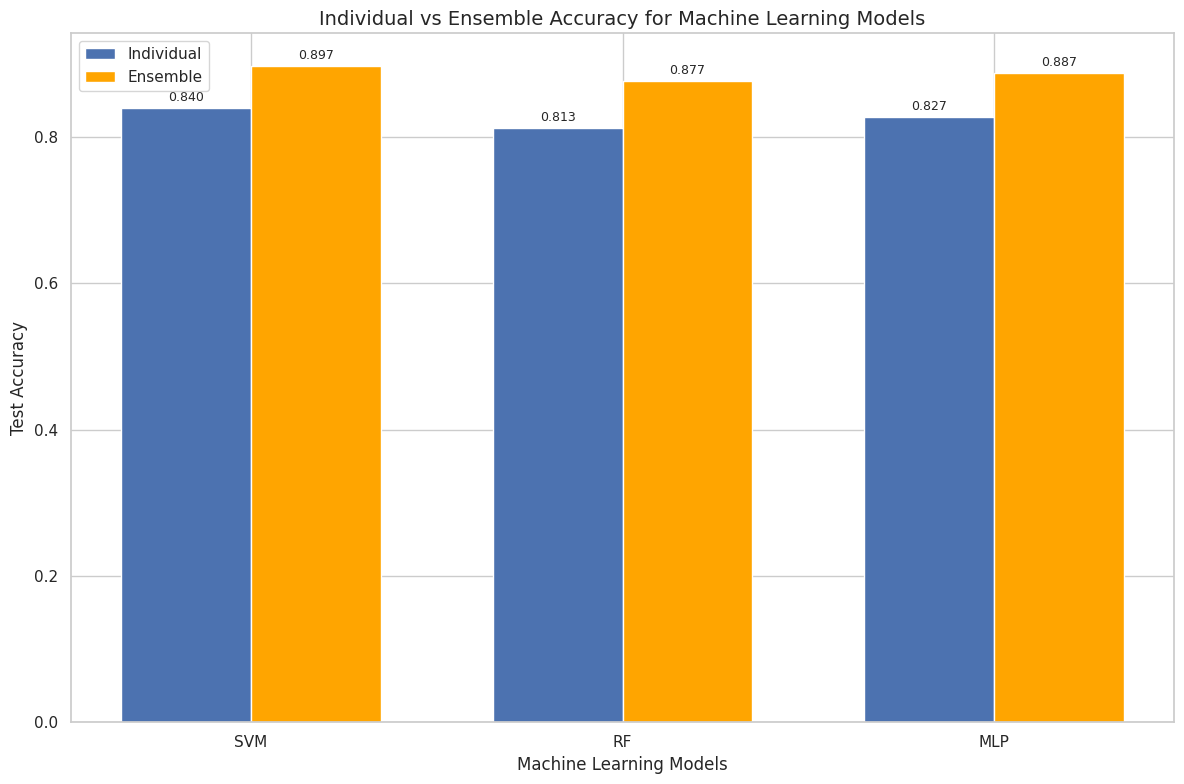

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
model_names = ["SVM", "RF", "MLP"]

# Initialize lists for individual and ensemble accuracies
individual_accuracies = []
ensemble_accuracies = []

# Calculate individual and ensemble accuracies for each model
for mdl in model_names:
    if mdl == "SVM":
        model_stats_mdl_data = model_stats_svm_data
    elif mdl == "RF":
        model_stats_mdl_data = model_stats_rf_data
    else:
        model_stats_mdl_data = model_stats_mlp_data

    # Individual accuracy: Average across embeddings
    mdl_individual_accuracies = [
        model_stats_mdl_data[f'Emb_{idx+1}']['test_accuracy']
        for idx in range(len(embedding_models_dict))
    ]
    individual_accuracies.append(np.mean(mdl_individual_accuracies))

    # Ensemble accuracy calculation
    df = df_same_mdl_all_emb[
        (df_same_mdl_all_emb['Model'] == mdl) &
        (df_same_mdl_all_emb['Y_Real/Test'] == "YPred")
    ].iloc[:, 3:]
    modes = df.mode().iloc[0]
    df.loc["Mode"] = modes
    df.loc["YReal"] = y_test

    correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
    total_predictions = df.shape[1]
    ensemble_accuracies.append(round(correct_predictions / total_predictions, 3))

# Setting up the bar chart
x = np.arange(len(model_names))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Bars for individual and ensemble accuracies
rects1 = ax.bar(x - width / 2, individual_accuracies, width, label='Individual')
rects2 = ax.bar(x + width / 2, ensemble_accuracies, width, label='Ensemble', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Machine Learning Models', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Individual vs Ensemble Accuracy for Machine Learning Models', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(model_names, ha='center')
ax.legend()

# Annotate bars with values
def add_bar_labels(rects, is_highlight=False):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text slightly above bars
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

add_bar_labels(rects1)
add_bar_labels(rects2, is_highlight=True)

fig.tight_layout()
plt.show()


### 1 Test Sample için 15 Sonuc Temsil(5) x Algoritm(3)

In [63]:
model_stats_svm_data
model_stats_rf_data
model_stats_mlp_data.keys()
model_stats_mdl_data[f"Emb_{idx+1}"]

for idx, emb in enumerate(embedding_models_dict.keys()):
    model_stats_svm_data[f"Emb_{idx+1}"]["y_pred"]
    model_stats_rf_data[f"Emb_{idx+1}"]["y_pred"]
    model_stats_mlp_data[f"Emb_{idx+1}"]["y_pred"]

In [64]:
df_same_mdl_all_emb = pd.DataFrame()

for mdl in ["SVM", "RF", "MLP"]:
    if mdl == "SVM":
        model_stats_mdl_data = model_stats_svm_data
    elif mdl == "RF":
        model_stats_mdl_data = model_stats_rf_data
    else:
        model_stats_mdl_data = model_stats_mlp_data

    for idx, emb in enumerate(embedding_models_dict):
        array1 = model_stats_mdl_data[f"Emb_{idx+1}"]["y_pred"]
        array1 = np.insert(array1.astype(object), 0, f"{mdl}")
        array1 = np.insert(array1.astype(object), 1, f"{emb}")
        array1 = np.insert(array1.astype(object), 2, "YPred")
        df_same_mdl_all_emb_tmp = pd.DataFrame([array1])
        df_same_mdl_all_emb = pd.concat([df_same_mdl_all_emb, df_same_mdl_all_emb_tmp])

df_same_mdl_all_emb.rename(columns={0:"Model", 1:"EmbeddingMethod", 2:"Y_Real/Test"}, inplace=True)

array0 = y_test
array0 = np.insert(array0.astype(object), 0, "No Model Name")
array0 = np.insert(array0.astype(object), 1, "No Emb. Method")
array0 = np.insert(array0.astype(object), 2, "YReal")

df_arr = pd.DataFrame([array0])
df_arr.rename(columns={0:"Model", 1:"EmbeddingMethod", 2:"Y_Real/Test"}, inplace=True)

# df_same_mdl_all_emb = pd.concat([df_same_mdl_all_emb, df_arr], ignore_index=True)
df_same_mdl_all_emb.reset_index(drop=True, inplace=True)
df_same_mdl_all_emb


df = df_same_mdl_all_emb.iloc[:, 3:]
modes = df.mode().iloc[0]
df.loc["Mode"] = modes
df.loc["YReal"] = y_test
df

3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  \
0      1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   1   1   1   1   
1      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
2      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
3      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
4      1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   0   1   0   1   
5      1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   0   1   1   1   
6      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
7      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
8      1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
9      1  0  0  0  1  0  1   0   0   1   0   1   1   1   0   0   1   1   1   
10     1  0  1  1  1  1  1   0   0   1   1   1   1   1   0   1   1   1   1   
11     1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
12     1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
13     1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
14     1  0  1  1  1  0  1   0   0   1   1   1   1   1   0   0   1   1   1   
Mode   1  0  0  0  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   
YReal  1  0  0  1  1  1  1   0   0   1   1   1   1   1   0   0   1   1   1   

       22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
0       1   1   1   0   1   1   1   0   0   0   1   1   1   0   0   1   0   0   
1       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
2       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
3       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
4       1   0   1   0   1   1   1   1   0   0   1   1   1   0   0   1   0   1   
5       1   0   1   0   1   1   1   0   0   0   1   0   1   0   0   0   0   0   
6       1   1   1   0   0   1   1   0   0   0   1   1   1   0   0   1   0   1   
7       1   1   1   0   1   1   1   0   0   0   1   0   1   0   0   1   0   1   
8       1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
9       1   0   1   0   1   1   0   0   0   0   1   1   1   0   0   1   0   0   
10      1   1   1   0   1   1   1   0   0   0   1   1   1   0   0   1   0   1   
11      1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
12      1   1   1   0   0   1   1   0   0   0   1   0   1   0   0   1   0   1   
13      1   1   1   0   1   1   1   0   0   0   1   0   1   0   0   1   0   1   
14      1   0   1   0   1   1   1   1   0   0   1   1   1   0   0   1   0   1   
Mode    1   1   1   0   1   1   1   0   0   0   1   0   1   0   0   1   0   1   
YReal   1   1   1   0   1   1   1   0   0   1   1   0   1   0   0   1   0   1   

       40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  \
0       0   0   1   0   1   1   0   0   0   0   1   1   0   1   0   1   0   1   
1       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
2       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
3       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
4       0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   1   
5       0   0   1   0   1   1   0   0   0   0   1   1   1   0   0   0   0   1   
6       0   0   1   0   1   1   0   1   0   0   1   1   1   1   0   1   1   0   
7       0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
8       0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   1   0   
9       0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   0   
10      0   0   1   0   1   1   0   0   0   0   1   1   1   1   0   1   0   1   
11      0   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
12      1   0   1   0   1   1   0   1   0   0   1   1   0   1   0   1   1   0   
13      0

In [65]:
correct_predictions = (df.loc["Mode"] == df.loc["YReal"]).sum()
total_predictions = df.shape[1]
accuracy = correct_predictions / total_predictions

print(f"Doğruluk Oranı: {accuracy:.3}")

Doğruluk Oranı: 0.895


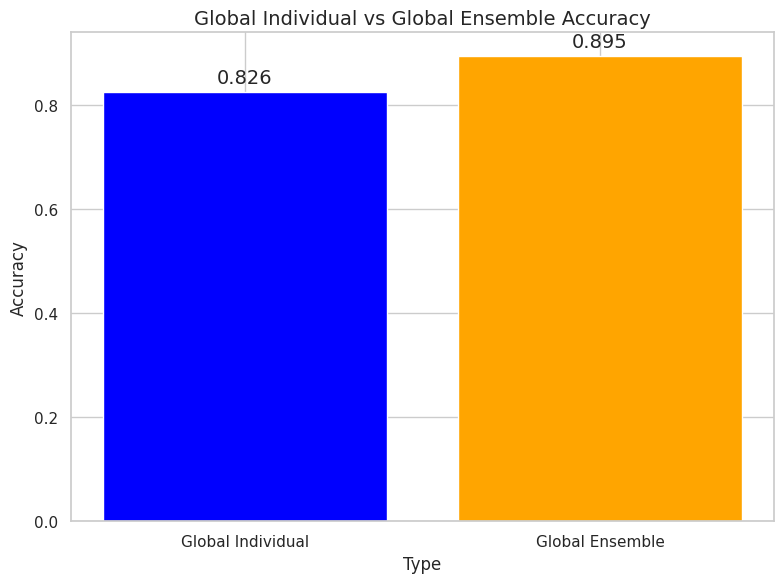

In [107]:
# Calculating overall ensemble accuracy (all 15 decisions combined)
df_combined = df_same_mdl_all_emb[
    df_same_mdl_all_emb['Y_Real/Test'] == "YPred"
].iloc[:, 3:]
modes_combined = df_combined.mode().iloc[0]
df_combined.loc["Mode"] = modes_combined
df_combined.loc["YReal"] = y_test

correct_predictions_combined = (df_combined.loc["Mode"] == df_combined.loc["YReal"]).sum()
total_predictions_combined = df_combined.shape[1]
ensemble_accuracy_combined = round(correct_predictions_combined / total_predictions_combined, 3)

# Individual accuracy (average of all individual models across all embeddings)
overall_individual_accuracy = round(np.mean(individual_accuracies), 3)

# Bar Chart for Individual vs Combined Ensemble Accuracy
x_labels = ['Global Individual', 'Global Ensemble']
accuracies = [overall_individual_accuracy, ensemble_accuracy_combined]

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(x_labels, accuracies, color=['blue', 'orange'])

# Add labels, title, and values above bars
ax.set_xlabel('Type', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Global Individual vs Global Ensemble Accuracy', fontsize=14)


for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above bars
                textcoords="offset points",
                ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.show()
